# Enhanced Black Hole Formation Analysis with Unit Conversion and Flexible Filtering
## Comprehensive Data Processing Pipeline with CMC Unit Conversion

This notebook implements your black hole formation analysis pipeline with integrated
CMC unit conversion using the cmc_parser library and flexible filtering capabilities.
All data is automatically converted from CMC code units to physical units (solar masses, Myr, parsecs).

In [2]:
# Essential imports for data parsing analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import re
import warnings
warnings.filterwarnings('ignore')


import cmc_parser as cp
CMC_PARSER_AVAILABLE = True


# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("All libraries imported successfully!")
print(f"Working directory: {os.getcwd()}")

All libraries imported successfully!
Working directory: c:\Users\ishaa\OneDrive\ドキュメント\Vscode\summer research


## Unit Conversion Functions
Functions for loading CMC conversion factors and converting data to physical units

In [3]:
def load_conversion_factors(model_path):

    
    conv_file_path = os.path.join(model_path, 'initial.conv.sh')

    # Load conversion factors using cmc_parser - exactly as you showed
    conv_file = cp.conversion_file(conv_file_path)
        
    # Extract the conversion factors you demonstrated
    conversion_factors = {
        'mass_msun_mstar': conv_file.mass_msun_mstar,  # For converting masses
        'time_myr': conv_file.time_myr,                # For converting times 
        'length_parsec': conv_file.length_parsec,      # For converting radii
        'conv_obj': conv_file                          # Store full object for reference
    }
        
    return conversion_factors
        


def apply_unit_conversion(data, conversion_factors, data_type='bh_formation'):
    """
    Apply unit conversion to loaded data while preserving ID fields
    """
    if conversion_factors is None or data is None:
        return data
    
    # Create a copy to avoid modifying original data
    converted_data = data.copy()
    
    # PROTECT ID FIELDS - these should NEVER be converted
    id_columns = ['ID', 'idm', 'id1', 'id2', 'id_rem']
    protected_ids = {}
    for col in id_columns:
        if col in converted_data.columns:
            protected_ids[col] = converted_data[col].copy()
    
    try:
        # Apply conversions based on data type
        if data_type == 'bh_formation':
            if 'time' in converted_data.columns:
                converted_data['time'] = converted_data['time'] * conversion_factors['time_myr']
            if 'r' in converted_data.columns:
                converted_data['r'] = converted_data['r'] * conversion_factors['length_parsec']
                
        elif data_type == 'collision':
            if 'time' in converted_data.columns:
                converted_data['time'] = converted_data['time'] * conversion_factors['time_myr']
            if 'r' in converted_data.columns:
                converted_data['r'] = converted_data['r'] * conversion_factors['length_parsec']
            # Convert masses from code units to solar masses
            mass_columns = ['m1', 'm2', 'mm']
            for col in mass_columns:
                if col in converted_data.columns:
                    converted_data[col] = converted_data[col] * conversion_factors['mass_msun_mstar']
                    
        elif data_type == 'merger':
            if 'time' in converted_data.columns:
                converted_data['time'] = converted_data['time'] * conversion_factors['time_myr']
            if 'r' in converted_data.columns:
                converted_data['r'] = converted_data['r'] * conversion_factors['length_parsec']
            # Convert masses from code units to solar masses
            mass_columns = ['m1', 'm2', 'mass_rem']
            for col in mass_columns:
                if col in converted_data.columns:
                    converted_data[col] = converted_data[col] * conversion_factors['mass_msun_mstar']
        
        # RESTORE PROTECTED ID FIELDS
        for col, original_values in protected_ids.items():
            converted_data[col] = original_values
            
        return converted_data
        
    except Exception as e:
        print(f"Error applying unit conversion: {e}")
        return data  # Return original data if conversion fails


## Model Name Parsing and Enhanced Model Discovery
Enhanced functions with flexible filtering by N and/or rv

def parse_model_name(model_name):
    """
    Parse model name to extract physical parameters N, rv, rg, Z
    
    Parameters:
    model_name (str): Model directory name in format N[number]rv[number]rg[number]Z[number]
    
    Returns:
    dict: Dictionary containing extracted parameters or None if parsing fails
    """
    # Pattern for format: N[number]rv[number]rg[number]Z[number]
    pattern = r'N([\\d\\.]+)rv([\\d\\.]+)rg([\\d\\.]+)Z([\\d\\.]+)'
    match = re.match(pattern, model_name)
    
    if match:
        return {
            'N': float(match.group(1)),
            'rv': float(match.group(2)), 
            'rg': float(match.group(3)),
            'Z': float(match.group(4)),
            'model_name': model_name
        }
    else:
        print(f"Warning: Could not parse {model_name}")
        return None

In [4]:

def parse_model_name(model_name: str):
    """
    Extract N, rv, rg and Z from directory names such as
    'N0.8rv0.75rg20Z0.002'  or  'N8e5rv0.75rg20z0.002_extra'.
    """
    # digits, dots, +, -, or scientific-notation letters
    num = r'([0-9.eE+-]+)'

    # ^ anchors at start; we don’t anchor at end so trailing text is allowed
    pattern = rf'^N{num}rv{num}rg{num}Z{num}'

    m = re.match(pattern, model_name, flags=re.IGNORECASE)
    if not m:
        # keep the warning so you can still see badly-named folders
        print(f"Warning: Could not parse {model_name}")
        return None

    return {
        'N':  float(m.group(1)),
        'rv': float(m.group(2)),
        'rg': float(m.group(3)),
        'Z':  float(m.group(4)),
        'model_name': model_name
    }


In [5]:
def discover_models_enhanced(data_directory, N_min=None, N_max=None, rv_min=None, rv_max=None):
    """
    Discover models with flexible filtering by N and/or rv
    ENHANCED VERSION - replaces simple max_rv filtering with comprehensive range filtering
    
    Parameters:
    data_directory (str): Path to directory containing model subdirectories
    N_min, N_max (float): Filter by number of stars (N) - optional
    rv_min, rv_max (float): Filter by virial radius (rv) - optional
    
    Returns:
    pd.DataFrame: DataFrame containing filtered models with derived parameters
    """
    model_dirs = []
    
    # Discover all valid model directories
    for item in os.listdir(data_directory):
        item_path = os.path.join(data_directory, item)
        if os.path.isdir(item_path):
            parsed = parse_model_name(item)
            if parsed:
                parsed['path'] = item_path
                model_dirs.append(parsed)
    
    models_df = pd.DataFrame(model_dirs)
    
    if models_df.empty:
        print("No valid models found!")
        return models_df
    
    original_count = len(models_df)
    print(f"Found {original_count} total models")
    
    # Apply filters progressively
    if N_min is not None:
        models_df = models_df[models_df['N'] >= N_min]
        print(f"Applied N >= {N_min} filter: {len(models_df)} models remain")
    
    if N_max is not None:
        models_df = models_df[models_df['N'] <= N_max]
        print(f"Applied N <= {N_max} filter: {len(models_df)} models remain")
    
    if rv_min is not None:
        models_df = models_df[models_df['rv'] >= rv_min]
        print(f"Applied rv >= {rv_min} filter: {len(models_df)} models remain")
    
    if rv_max is not None:
        models_df = models_df[models_df['rv'] <= rv_max]
        print(f"Applied rv <= {rv_max} filter: {len(models_df)} models remain")
    
    print(f"Final filtered dataset: {len(models_df)} models")
    
    # Add derived parameters for advanced analysis
    models_df['log_N'] = np.log10(models_df['N'])
    models_df['log_Z'] = np.log10(models_df['Z'])
    models_df['density_proxy'] = models_df['N'] / (models_df['rv']**3)  # Rough density estimate
    
    return models_df.reset_index(drop=True)

## Enhanced Data Loading Functions with Unit Conversion
All data loading functions automatically convert to physical units

In [6]:
def load_bh_formation_data_enhanced_with_units(model_path, convert_units=True):
    """
    Enhanced BH formation data loader with automatic unit conversion
    
    Parameters:
    model_path (str): Path to model directory
    convert_units (bool): Whether to apply unit conversion
    
    Returns:
    tuple: (DataFrame of BH data, filename used) or (None, None) if failed
    """
    # Load conversion factors if unit conversion is requested
    conversion_factors = None
    if convert_units:
        conversion_factors = load_conversion_factors(model_path)
    
    # Look for BH formation files
    possible_files = [
        'initial.bheformation.dat',
        'initial.bhformation.dat', 
        'initial.bh.dat'
    ]
    
    for filename in possible_files:
        filepath = os.path.join(model_path, filename)
        if os.path.exists(filepath):
            try:
                # Read all lines manually to handle variable columns
                data_rows = []
                with open(filepath, 'r') as f:
                    for line in f:
                        if not line.startswith('#') and line.strip():
                            # Split and take only first 9 columns
                            parts = line.strip().split()
                            if len(parts) >= 9:
                                data_rows.append(parts[:9])
                
                if data_rows:
                    # Standard column names for first 9 columns
                    columns = ['time', 'r', 'binary', 'ID', 'zams_m', 
                              'm_progenitor', 'bh_mass', 'bh_spin', 'birth_kick']
                    
                    df = pd.DataFrame(data_rows, columns=columns)
                    
                    # Convert to numeric, handling any remaining issues
                    numeric_cols = ['time', 'r', 'zams_m', 'm_progenitor', 
                                   'bh_mass', 'bh_spin', 'birth_kick']
                    for col in numeric_cols:
                        df[col] = pd.to_numeric(df[col], errors='coerce')
                    
                    df['binary'] = pd.to_numeric(df['binary'], errors='coerce').astype(int)
                    df['ID'] = pd.to_numeric(df['ID'], errors='coerce').astype(int)
                    
                    # Apply unit conversion if available
                    if convert_units and conversion_factors is not None:
                        df = apply_unit_conversion(df, conversion_factors, 'bh_formation')
                    
                    return df, filename
                
            except Exception as e:
                print(f"Error loading {filename}: {e}")
                continue
    
    return None, None

In [7]:
def load_collision_data_enhanced_with_units(model_path, convert_units=True):
    """
    Enhanced collision data loader with automatic unit conversion
    FIXED: Corrected regex patterns and return logic

    Parameters:
    model_path (str): Path to model directory
    convert_units (bool): Whether to apply unit conversion

    Returns:
    pd.DataFrame: DataFrame containing collision events or None if failed
    """
    # Load conversion factors if unit conversion is requested
    conversion_factors = None
    if convert_units:
        conversion_factors = load_conversion_factors(model_path)

    collision_file = os.path.join(model_path, 'initial.collision.log')
    if not os.path.exists(collision_file):
        return None

    data = {
        'time': [], 'collision_type': [], 'idm': [], 'mm': [],
        'id1': [], 'm1': [], 'id2': [], 'm2': [], 'r': [],
        'typem': [], 'type1': [], 'type2': []
    }

    try:
        with open(collision_file, 'r') as file:
            for line in file:
                if line.startswith('t='):
                    # FIXED: Removed double backslashes - use single backslashes in raw strings
                    time_match = re.search(r't=([\d.eE+-]+)', line)
                    type_match = re.search(r'\s(binary-[a-z]+|single-single)\s', line)
                    idm_mm_match = re.search(r'idm=(\d+)\(mm=([\d.eE+-]+)\)', line)
                    id1_m1_match = re.search(r'id1=(\d+)\(m1=([\d.eE+-]+)\)', line)
                    # CRITICAL FIX: Handle colon and space in format "id1=286760(m1=0.669391):id2=415309 (m2=0.426012)"
                    id2_m2_match = re.search(r'id2=(\d+)[\s:]*\(m2=([\d.eE+-]+)\)', line)
                    r_match = re.search(r'\(r=([\d.eE+-]+)\)', line)
                    typem_match = re.search(r'typem=(\d+)', line)
                    type1_match = re.search(r'type1=(\d+)', line)
                    type2_match = re.search(r'type2=(\d+)', line)

                    if all([time_match, type_match, idm_mm_match, id1_m1_match, 
                           id2_m2_match, r_match, typem_match, type1_match, type2_match]):
                        data['time'].append(float(time_match.group(1)))
                        data['collision_type'].append(type_match.group(1))
                        data['idm'].append(int(idm_mm_match.group(1)))
                        data['mm'].append(float(idm_mm_match.group(2)))
                        data['id1'].append(int(id1_m1_match.group(1)))
                        data['m1'].append(float(id1_m1_match.group(2)))
                        data['id2'].append(int(id2_m2_match.group(1)))
                        data['m2'].append(float(id2_m2_match.group(2)))
                        data['r'].append(float(r_match.group(1)))
                        data['typem'].append(int(typem_match.group(1)))
                        data['type1'].append(int(type1_match.group(1)))
                        data['type2'].append(int(type2_match.group(1)))

        # FIXED: Only return DataFrame if data was actually parsed
        if data['time']:
            df = pd.DataFrame(data)

            # Apply unit conversion if available
            if convert_units and conversion_factors is not None:
                df = apply_unit_conversion(df, conversion_factors, 'collision')

            return df
        else:
            return None

    except Exception as e:
        print(f"Error loading collision data: {e}")
        return None

In [90]:
x= load_collision_data_enhanced_with_units('data/N8rv0.75rg20Z0.002',convert_units=False)
print(x)

None


In [9]:
def load_merger_data_enhanced_with_units(model_path, convert_units=True):
    """
    Enhanced merger data loader with automatic unit conversion
    FIXED: Corrected regex patterns and return logic

    Parameters:
    model_path (str): Path to model directory
    convert_units (bool): Whether to apply unit conversion

    Returns:
    pd.DataFrame: DataFrame containing merger events or None if failed
    """
    # Load conversion factors if unit conversion is requested
    conversion_factors = None
    if convert_units:
        conversion_factors = load_conversion_factors(model_path)

    merger_file = os.path.join(model_path, 'initial.semergedisrupt.log')
    if not os.path.exists(merger_file):
        return None

    data = {
        'time': [], 'interaction_type': [], 'id_rem': [], 'mass_rem': [],
        'id1': [], 'm1': [], 'id2': [], 'm2': [], 'r': [],
        'type_rem': [], 'type1': [], 'type2': []
    }

    try:
        with open(merger_file, 'r') as file:
            for line in file:
                if line.startswith('t='):
                    # FIXED: Removed double backslashes
                    time_match = re.search(r't=([\d.eE+-]+)', line)
                    type_match = re.search(r'\s(disrupt1|disrupt2|disruptboth|merge)\s', line)
                    id_rem_match = re.search(r'idr=(\d+)\(mr=([\d.eE+-]+)\)', line)
                    id1_m1_match = re.search(r'id1=(\d+)\(m1=([\d.eE+-]+)\)', line)
                    id2_m2_match = re.search(r'id2=(\d+)\(m2=([\d.eE+-]+)\)', line)
                    r_match = re.search(r'\(r=([\d.eE+-]+)\)', line)
                    type_rem_match = re.search(r'typer=(\d+)', line)
                    type1_match = re.search(r'type1=(\d+)', line)
                    type2_match = re.search(r'type2=(\d+)', line)

                    # Only require essential matches for mergers
                    if time_match and id1_m1_match and id2_m2_match:
                        data['time'].append(float(time_match.group(1)))
                        data['interaction_type'].append(type_match.group(1) if type_match else 'unknown')

                        if id_rem_match:
                            data['id_rem'].append(int(id_rem_match.group(1)))
                            data['mass_rem'].append(float(id_rem_match.group(2)))
                        else:
                            data['id_rem'].append(-1)
                            data['mass_rem'].append(0.0)

                        data['id1'].append(int(id1_m1_match.group(1)))
                        data['m1'].append(float(id1_m1_match.group(2)))
                        data['id2'].append(int(id2_m2_match.group(1)))
                        data['m2'].append(float(id2_m2_match.group(2)))
                        data['r'].append(float(r_match.group(1)) if r_match else 0.0)
                        data['type_rem'].append(int(type_rem_match.group(1)) if type_rem_match else -1)
                        data['type1'].append(int(type1_match.group(1)) if type1_match else -1)
                        data['type2'].append(int(type2_match.group(1)) if type2_match else -1)

        # FIXED: Only return DataFrame if data was actually parsed
        if data['time']:
            df = pd.DataFrame(data)

            # Apply unit conversion if available
            if convert_units and conversion_factors is not None:
                df = apply_unit_conversion(df, conversion_factors, 'merger')

            return df
        else:
            return None

    except Exception as e:
        print(f"Error loading merger data: {e}")
        return None

## Comprehensive DataFrame Generation Functions
Functions to create the three requested datasets with complete model parameter information

In [10]:
def create_all_bh_dataframe_with_units(models_df, convert_units=True):
    """
    Create comprehensive dataframe of ALL black holes from the filtered models
    Includes complete model parameters for each BH with unit conversion
    
    Parameters:
    models_df (pd.DataFrame): DataFrame of filtered models
    convert_units (bool): Whether to apply unit conversion
    
    Returns:
    pd.DataFrame: Comprehensive dataset of all black holes with model parameters
    """
    all_bhs = []
    
    for idx, model_info in models_df.iterrows():
        print(f"Processing model {idx+1}/{len(models_df)}: {model_info['model_name']}")
        
        # Load BH formation data with unit conversion
        bh_data, bh_file = load_bh_formation_data_enhanced_with_units(model_info['path'], convert_units)
        
        if bh_data is not None and len(bh_data) > 0:
            # Add comprehensive model parameters to each BH row
            bh_data_with_params = bh_data.copy()
            bh_data_with_params['model_name'] = model_info['model_name']
            bh_data_with_params['model_N'] = model_info['N']
            bh_data_with_params['model_rv'] = model_info['rv']
            bh_data_with_params['model_rg'] = model_info['rg']
            bh_data_with_params['model_Z'] = model_info['Z']
            bh_data_with_params['model_log_N'] = model_info['log_N']
            bh_data_with_params['model_log_Z'] = model_info['log_Z']
            bh_data_with_params['model_density_proxy'] = model_info['density_proxy']
            bh_data_with_params['units_converted'] = convert_units
            
            all_bhs.append(bh_data_with_params)
    
    if all_bhs:
        result_df = pd.concat(all_bhs, ignore_index=True)
        print(f"\nCreated comprehensive BH dataset with {len(result_df)} black holes")
        if convert_units:
            print("✓ All data converted to physical units (M☉, Myr, pc)")
        return result_df
    else:
        print("No black holes found in any models!")
        return pd.DataFrame()

In [11]:
def create_collision_bh_dataframe_with_units(models_df, convert_units=True):
    """
    Create dataframe of black holes formed from COLLISIONS
    Uses pandas merge approach consistent with Data_test_3
    
    Parameters:
    models_df (pd.DataFrame): DataFrame of filtered models
    convert_units (bool): Whether to apply unit conversion
    
    Returns:
    pd.DataFrame: Dataset of collision-formed black holes with collision details
    """
    collision_bhs = []
    
    for idx, model_info in models_df.iterrows():
        print(f"Processing model {idx+1}/{len(models_df)}: {model_info['model_name']}")
        
        # Load required data with unit conversion
        bh_data, _ = load_bh_formation_data_enhanced_with_units(model_info['path'], convert_units)
        collision_data = load_collision_data_enhanced_with_units(model_info['path'], convert_units)
        
        if bh_data is not None and collision_data is not None:
            # Use pandas merge with idm (collision product ID)
            # This matches Data_test_3 approach: collision_df + bh_data on idm=ID
            collision_bhs_subset = pd.merge(
                collision_data, 
                bh_data, 
                left_on='idm', 
                right_on='ID', 
                how='inner'
            )
            
            if not collision_bhs_subset.empty:
                # Add comprehensive model parameters
                collision_bhs_subset['model_name'] = model_info['model_name']
                collision_bhs_subset['model_N'] = model_info['N']
                collision_bhs_subset['model_rv'] = model_info['rv']
                collision_bhs_subset['model_rg'] = model_info['rg']
                collision_bhs_subset['model_Z'] = model_info['Z']
                collision_bhs_subset['formation_mechanism'] = 'collision'
                collision_bhs_subset['units_converted'] = convert_units
                
                # Rename columns to match expected format
                collision_bhs_subset = collision_bhs_subset.rename(columns={
                    'time_y': 'time',  # BH formation time
                    'r_y': 'r',        # BH formation radius
                    'time_x': 'collision_time',  # Collision event time
                    'r_x': 'collision_location'  # Collision location
                })
                
                # Add calculated fields
                collision_bhs_subset['progenitor_mass_1'] = collision_bhs_subset['m1']
                collision_bhs_subset['progenitor_mass_2'] = collision_bhs_subset['m2']
                collision_bhs_subset['stellar_type_1'] = collision_bhs_subset['type1']
                collision_bhs_subset['stellar_type_2'] = collision_bhs_subset['type2']
                collision_bhs_subset['total_progenitor_mass'] = collision_bhs_subset['m1'] + collision_bhs_subset['m2']
                collision_bhs_subset['mass_ratio'] = (
                    collision_bhs_subset[['m1', 'm2']].min(axis=1) / 
                    collision_bhs_subset[['m1', 'm2']].max(axis=1)
                )
                
                collision_bhs.append(collision_bhs_subset)
    
    if collision_bhs:
        result_df = pd.concat(collision_bhs, ignore_index=True)
        print(f"\nCreated collision BH dataset with {len(result_df)} black holes")
        if convert_units:
            print("✓ All data converted to physical units (M☉, Myr, pc)")
        return result_df
    else:
        print("No collision-formed black holes found!")
        return pd.DataFrame()


In [12]:
def create_merger_bh_dataframe_with_units(models_df, convert_units=True):
    """
    Create dataframe of black holes formed from MERGERS
    Uses correct id_rem matching as in Data_test_3
    
    Parameters:
    models_df (pd.DataFrame): DataFrame of filtered models
    convert_units (bool): Whether to apply unit conversion
    
    Returns:
    pd.DataFrame: Dataset of merger-formed black holes with merger details
    """
    merger_bhs = []
    
    for idx, model_info in models_df.iterrows():
        print(f"Processing model {idx+1}/{len(models_df)}: {model_info['model_name']}")
        
        # Load required data with unit conversion
        bh_data, _ = load_bh_formation_data_enhanced_with_units(model_info['path'], convert_units)
        merger_data = load_merger_data_enhanced_with_units(model_info['path'], convert_units)
        
        if bh_data is not None and merger_data is not None:
     
            merger_bhs_subset = pd.merge(
                merger_data, 
                bh_data, 
                left_on='id_rem', 
                right_on='ID', 
                how='inner'
            )
            
            if not merger_bhs_subset.empty:
                # Add comprehensive model parameters
                merger_bhs_subset['model_name'] = model_info['model_name']
                merger_bhs_subset['model_N'] = model_info['N']
                merger_bhs_subset['model_rv'] = model_info['rv']
                merger_bhs_subset['model_rg'] = model_info['rg']
                merger_bhs_subset['model_Z'] = model_info['Z']
                merger_bhs_subset['formation_mechanism'] = 'merger'
                merger_bhs_subset['units_converted'] = convert_units
                
                # Rename columns to match expected format
                merger_bhs_subset = merger_bhs_subset.rename(columns={
                    'time_y': 'time',  # BH formation time
                    'r_y': 'r',        # BH formation radius
                    'time_x': 'merger_time',  # Merger event time
                    'r_x': 'merger_location',  # Merger location
                    'interaction_type': 'merger_type'
                })
                
                # Add calculated fields
                merger_bhs_subset['progenitor_mass_1'] = merger_bhs_subset['m1']
                merger_bhs_subset['progenitor_mass_2'] = merger_bhs_subset['m2']
                merger_bhs_subset['stellar_type_1'] = merger_bhs_subset['type1']
                merger_bhs_subset['stellar_type_2'] = merger_bhs_subset['type2']
                merger_bhs_subset['total_progenitor_mass'] = merger_bhs_subset['m1'] + merger_bhs_subset['m2']
                merger_bhs_subset['mass_ratio'] = (
                    merger_bhs_subset[['m1', 'm2']].min(axis=1) / 
                    merger_bhs_subset[['m1', 'm2']].max(axis=1)
                )
                
                merger_bhs.append(merger_bhs_subset)
    
    if merger_bhs:
        result_df = pd.concat(merger_bhs, ignore_index=True)
        print(f"\nCreated merger BH dataset with {len(result_df)} black holes")
        if convert_units:
            print("✓ All data converted to physical units (M☉, Myr, pc)")
        return result_df
    else:
        print("No merger-formed black holes found!")
        return pd.DataFrame()


## Analysis and Utility Functions
Functions for analyzing the generated datasets and saving results

In [13]:
def analyze_bh_datasets(all_bhs_df, collision_bhs_df, merger_bhs_df):
    """
    Provide comprehensive summary statistics for the three BH datasets
    
    Parameters:
    all_bhs_df, collision_bhs_df, merger_bhs_df (pd.DataFrame): The three BH datasets
    """
    print("="*70)
    print("COMPREHENSIVE BLACK HOLE DATASET ANALYSIS")
    print("="*70)
    
    print(f"\n1. ALL BLACK HOLES DATASET:")
    print(f"   Total black holes: {len(all_bhs_df):,}")
    if len(all_bhs_df) > 0:
        units_str = "M☉" if all_bhs_df['units_converted'].iloc[0] else "code units"
        time_units = "Myr" if all_bhs_df['units_converted'].iloc[0] else "code units"
        dist_units = "pc" if all_bhs_df['units_converted'].iloc[0] else "code units"
        
        print(f"   Mass range: {all_bhs_df['bh_mass'].min():.2f} - {all_bhs_df['bh_mass'].max():.2f} {units_str}")
        print(f"   Mean mass: {all_bhs_df['bh_mass'].mean():.2f} ± {all_bhs_df['bh_mass'].std():.2f} {units_str}")
        print(f"   Median mass: {all_bhs_df['bh_mass'].median():.2f} {units_str}")
        print(f"   Number with non-zero spin: {(all_bhs_df['bh_spin'] > 0).sum():,}")
        print(f"   High-spin fraction: {(all_bhs_df['bh_spin'] > 0).mean()*100:.2f}%")
        print(f"   Unique models represented: {all_bhs_df['model_name'].nunique()}")
        print(f"   Formation radius range: {all_bhs_df['r'].min():.3f} - {all_bhs_df['r'].max():.3f} {dist_units}")
    
    print(f"\n2. COLLISION-FORMED BLACK HOLES DATASET:")
    print(f"   Total collision BHs: {len(collision_bhs_df):,}")
    if len(collision_bhs_df) > 0:
        units_str = "M☉" if collision_bhs_df['units_converted'].iloc[0] else "code units"
        print(f"   Mass range: {collision_bhs_df['bh_mass'].min():.2f} - {collision_bhs_df['bh_mass'].max():.2f} {units_str}")
        print(f"   Mean mass: {collision_bhs_df['bh_mass'].mean():.2f} ± {collision_bhs_df['bh_mass'].std():.2f} {units_str}")
        print(f"   Median mass: {collision_bhs_df['bh_mass'].median():.2f} {units_str}")
        print(f"   Unique models represented: {collision_bhs_df['model_name'].nunique()}")
        if 'collision_type' in collision_bhs_df.columns:
            print(f"   Collision types: {collision_bhs_df['collision_type'].value_counts().to_dict()}")
        if 'total_progenitor_mass' in collision_bhs_df.columns:
            print(f"   Mean progenitor mass: {collision_bhs_df['total_progenitor_mass'].mean():.2f} {units_str}")
    
    print(f"\n3. MERGER-FORMED BLACK HOLES DATASET:")
    print(f"   Total merger BHs: {len(merger_bhs_df):,}")
    if len(merger_bhs_df) > 0:
        units_str = "M☉" if merger_bhs_df['units_converted'].iloc[0] else "code units"
        print(f"   Mass range: {merger_bhs_df['bh_mass'].min():.2f} - {merger_bhs_df['bh_mass'].max():.2f} {units_str}")
        print(f"   Mean mass: {merger_bhs_df['bh_mass'].mean():.2f} ± {merger_bhs_df['bh_mass'].std():.2f} {units_str}")
        print(f"   Median mass: {merger_bhs_df['bh_mass'].median():.2f} {units_str}")
        print(f"   Unique models represented: {merger_bhs_df['model_name'].nunique()}")
        if 'merger_type' in merger_bhs_df.columns:
            print(f"   Merger types: {merger_bhs_df['merger_type'].value_counts().to_dict()}")
        if 'total_progenitor_mass' in merger_bhs_df.columns:
            print(f"   Mean progenitor mass: {merger_bhs_df['total_progenitor_mass'].mean():.2f} {units_str}")
    
    # Formation mechanism breakdown
    if len(all_bhs_df) > 0:
        collision_pct = len(collision_bhs_df) / len(all_bhs_df) * 100
        merger_pct = len(merger_bhs_df) / len(all_bhs_df) * 100
        normal_pct = 100 - collision_pct - merger_pct
        
        print(f"\n4. FORMATION MECHANISM BREAKDOWN:")
        print(f"   Collision-formed: {collision_pct:.1f}% ({len(collision_bhs_df):,} BHs)")
        print(f"   Merger-formed: {merger_pct:.1f}% ({len(merger_bhs_df):,} BHs)")
        print(f"   Normal evolution: {normal_pct:.1f}% ({len(all_bhs_df) - len(collision_bhs_df) - len(merger_bhs_df):,} BHs)")
    
    print("="*70)

In [14]:
def save_datasets_to_csv(all_bhs_df, collision_bhs_df, merger_bhs_df, prefix="enhanced_bh_analysis"):
    """
    Save the three comprehensive datasets to CSV files with detailed naming
    
    Parameters:
    all_bhs_df, collision_bhs_df, merger_bhs_df (pd.DataFrame): The three BH datasets
    prefix (str): Prefix for output filenames
    """
    # Generate timestamp for unique filenames
    from datetime import datetime
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save datasets with descriptive names
    all_filename = f"{prefix}_all_black_holes_{timestamp}.csv"
    collision_filename = f"{prefix}_collision_black_holes_{timestamp}.csv"
    merger_filename = f"{prefix}_merger_black_holes_{timestamp}.csv"
    
    all_bhs_df.to_csv(all_filename, index=False)
    collision_bhs_df.to_csv(collision_filename, index=False)
    merger_bhs_df.to_csv(merger_filename, index=False)
    
    print(f"\nSaved enhanced datasets:")
    print(f"  - {all_filename} ({len(all_bhs_df):,} rows, {len(all_bhs_df.columns)} columns)")
    print(f"  - {collision_filename} ({len(collision_bhs_df):,} rows, {len(collision_bhs_df.columns)} columns)")
    print(f"  - {merger_filename} ({len(merger_bhs_df):,} rows, {len(merger_bhs_df.columns)} columns)")
    
    return all_filename, collision_filename, merger_filename

## Main Execution Pipeline
Run the complete enhanced analysis with flexible filtering and unit conversion

In [15]:
# Configuration parameters 
DATA_DIRECTORY = "data"  

# ENHANCED FILTERING PARAMETERS - set to None to disable a filter
N_MIN = None     
N_MAX = None      
RV_MIN = None    
RV_MAX = 1.1      

# Unit conversion setting
CONVERT_UNITS = True  # Set to False to work with raw CMC code units

print("Starting enhanced black hole formation analysis...")
print(f"Data directory: {DATA_DIRECTORY}")
print(f"Enhanced filters: N=[{N_MIN}, {N_MAX}], rv=[{RV_MIN}, {RV_MAX}]")
print(f"Unit conversion: {'ENABLED' if CONVERT_UNITS else 'DISABLED'}")


Starting enhanced black hole formation analysis...
Data directory: data
Enhanced filters: N=[None, None], rv=[None, 1.1]
Unit conversion: ENABLED


In [16]:
# Step 1: Discover and filter models using ENHANCED filtering
print("\nStep 1: Discovering and filtering models with enhanced filtering...")
models_df = discover_models_enhanced(
    DATA_DIRECTORY, 
    N_min=N_MIN, N_max=N_MAX, 
    rv_min=RV_MIN, rv_max=RV_MAX
)



print(f"\nFiltered model summary:")
print(f"Parameter ranges in filtered dataset:")
for param in ['N', 'rv', 'rg', 'Z']:
    print(f"  {param}: {models_df[param].min():.3f} - {models_df[param].max():.3f}")

print(f"\nFirst 5 filtered models:")
print(models_df[['model_name', 'N', 'rv', 'rg', 'Z']].head())


Step 1: Discovering and filtering models with enhanced filtering...
Found 145 total models
Applied rv <= 1.1 filter: 71 models remain
Final filtered dataset: 71 models

Filtered model summary:
Parameter ranges in filtered dataset:
  N: 2.000 - 32.000
  rv: 0.500 - 1.000
  rg: 2.000 - 20.000
  Z: 0.000 - 0.020

First 5 filtered models:
             model_name     N   rv    rg      Z
0   N16rv0.5rg2.0Z0.002  16.0  0.5   2.0  0.002
1    N16rv0.5rg2.0Z0.02  16.0  0.5   2.0  0.020
2  N16rv0.5rg20.0Z0.002  16.0  0.5  20.0  0.002
3   N16rv0.5rg20.0Z0.02  16.0  0.5  20.0  0.020
4   N16rv0.5rg8.0Z0.002  16.0  0.5   8.0  0.002


In [17]:
# Step 2: Create the three comprehensive datasets with unit conversion


print("\nCreating dataset 1: ALL BLACK HOLES")
all_bhs_df = create_all_bh_dataframe_with_units(models_df, convert_units=CONVERT_UNITS)

print("\nCreating dataset 2: COLLISION-FORMED BLACK HOLES")
collision_bhs_df = create_collision_bh_dataframe_with_units(models_df, convert_units=CONVERT_UNITS)

print("\nCreating dataset 3: MERGER-FORMED BLACK HOLES")
merger_bhs_df = create_merger_bh_dataframe_with_units(models_df, convert_units=CONVERT_UNITS)

print("\nDataset creation complete!")


Creating dataset 1: ALL BLACK HOLES
Processing model 1/71: N16rv0.5rg2.0Z0.002
Processing model 2/71: N16rv0.5rg2.0Z0.02
Processing model 3/71: N16rv0.5rg20.0Z0.002
Processing model 4/71: N16rv0.5rg20.0Z0.02
Processing model 5/71: N16rv0.5rg8.0Z0.002
Processing model 6/71: N16rv0.5rg8.0Z0.02
Processing model 7/71: N16rv1.0rg2.0Z0.0002
Processing model 8/71: N16rv1.0rg2.0Z0.002
Processing model 9/71: N16rv1.0rg2.0Z0.02
Processing model 10/71: N16rv1.0rg20.0Z0.0002
Processing model 11/71: N16rv1.0rg20.0Z0.002
Processing model 12/71: N16rv1.0rg20.0Z0.02
Processing model 13/71: N16rv1.0rg8.0Z0.0002
Processing model 14/71: N16rv1.0rg8.0Z0.002
Processing model 15/71: N16rv1.0rg8.0Z0.02
Processing model 16/71: N2.0rv0.5rg2.0Z0.0002
Processing model 17/71: N2.0rv0.5rg2.0Z0.002
Processing model 18/71: N2.0rv0.5rg2.0Z0.02
Processing model 19/71: N2.0rv0.5rg20.0Z0.0002
Processing model 20/71: N2.0rv0.5rg20.0Z0.002
Processing model 21/71: N2.0rv0.5rg20.0Z0.02
Processing model 22/71: N2.0rv0.5rg8.

In [18]:
# Step 3: Analyze the datasets

analyze_bh_datasets(all_bhs_df, collision_bhs_df, merger_bhs_df)

COMPREHENSIVE BLACK HOLE DATASET ANALYSIS

1. ALL BLACK HOLES DATASET:
   Total black holes: 98,558
   Mass range: -0.05 - 253.37 M☉
   Mean mass: 14.44 ± 8.73 M☉
   Median mass: 13.03 M☉
   Number with non-zero spin: 7
   High-spin fraction: 0.01%
   Unique models represented: 71
   Formation radius range: 0.000 - 98.807 pc

2. COLLISION-FORMED BLACK HOLES DATASET:
   Total collision BHs: 35,821
   Mass range: -0.05 - 253.37 M☉
   Mean mass: 13.94 ± 10.41 M☉
   Median mass: 10.05 M☉
   Unique models represented: 71
   Collision types: {'single-single': 21342, 'binary-binary': 11774, 'binary-single': 2705}
   Mean progenitor mass: 16.62 M☉

3. MERGER-FORMED BLACK HOLES DATASET:
   Total merger BHs: 12,752
   Mass range: 0.00 - 253.37 M☉
   Mean mass: 20.91 ± 13.42 M☉
   Median mass: 17.21 M☉
   Unique models represented: 71
   Merger types: {'disrupt1': 9740, 'disrupt2': 3012}
   Mean progenitor mass: 33.25 M☉

4. FORMATION MECHANISM BREAKDOWN:
   Collision-formed: 36.3% (35,821 BHs)
 

In [19]:
# Step 4: Save datasets to CSV files

#saved_files = save_datasets_to_csv(all_bhs_df, collision_bhs_df, merger_bhs_df)

print("\nAnalysis pipeline completed successfully!")
print(f"Generated {len(all_bhs_df):,} total black hole records from {len(models_df)} models")
if CONVERT_UNITS:
    print("✓ All data saved in physical units (M☉, Myr, pc)")
else:
    print("⚠ Data saved in CMC code units")


Analysis pipeline completed successfully!
Generated 98,558 total black hole records from 71 models
✓ All data saved in physical units (M☉, Myr, pc)


## Dataset Inspection and Validation
Quick inspection of the generated datasets

In [20]:
# Inspect the structure of each dataset
print("Dataset structure inspection:")
print("\n1. ALL BLACK HOLES dataset columns:")
if len(all_bhs_df) > 0:
    print(f"   Columns ({len(all_bhs_df.columns)}): {list(all_bhs_df.columns)}")
    print(f"   Sample data:")
    print(all_bhs_df.head(3))

print("\n2. COLLISION BLACK HOLES dataset columns:")
if len(collision_bhs_df) > 0:
    print(f"   Columns ({len(collision_bhs_df.columns)}): {list(collision_bhs_df.columns)}")
    print(f"   Sample data:")
    print(collision_bhs_df.head(3))

print("\n3. MERGER BLACK HOLES dataset columns:")
if len(merger_bhs_df) > 0:
    print(f"   Columns ({len(merger_bhs_df.columns)}): {list(merger_bhs_df.columns)}")
    print(f"   Sample data:")
    print(merger_bhs_df.head(3))

Dataset structure inspection:

1. ALL BLACK HOLES dataset columns:
   Columns (18): ['time', 'r', 'binary', 'ID', 'zams_m', 'm_progenitor', 'bh_mass', 'bh_spin', 'birth_kick', 'model_name', 'model_N', 'model_rv', 'model_rg', 'model_Z', 'model_log_N', 'model_log_Z', 'model_density_proxy', 'units_converted']
   Sample data:
       time         r  binary       ID   zams_m  m_progenitor  bh_mass  \
0  3.646477  0.030642       1  1747662    0.000       36.5792  32.9213   
1  3.658199  0.671370       0  1251321  138.870       46.5021  41.8519   
2  3.664091  1.776460       0  1522758  137.253       46.4944  41.8450   

   bh_spin  birth_kick           model_name  model_N  model_rv  model_rg  \
0      0.0         0.0  N16rv0.5rg2.0Z0.002     16.0       0.5       2.0   
1      0.0         1.0  N16rv0.5rg2.0Z0.002     16.0       0.5       2.0   
2      0.0         1.0  N16rv0.5rg2.0Z0.002     16.0       0.5       2.0   

   model_Z  model_log_N  model_log_Z  model_density_proxy  units_converted

## Unit Conversion Validation
Validate that unit conversion is working correctly

In [21]:
# Test unit conversion validation if enabled
if CONVERT_UNITS and CMC_PARSER_AVAILABLE and len(models_df) > 0:
    print("VALIDATION: Testing unit conversion accuracy")
    print("="*60)
    
    test_model = models_df.iloc[20]
    print(f"Test model: {test_model['model_name']}")
    
    # Load data without conversion
    bh_raw, _ = load_bh_formation_data_enhanced_with_units(test_model['path'], convert_units=False)
    collision_raw = load_collision_data_enhanced_with_units(test_model['path'], convert_units=False)
    
    # Load data with conversion  
    bh_converted, _ = load_bh_formation_data_enhanced_with_units(test_model['path'], convert_units=True)
    collision_converted = load_collision_data_enhanced_with_units(test_model['path'], convert_units=True)
    
    # Load conversion factors to check the ratios
    conv_factors = load_conversion_factors(test_model['path'])
    
    if conv_factors and bh_raw is not None and bh_converted is not None:
        print(f"\nConversion factors for this model:")
        print(f"  mass_msun_mstar: {conv_factors['mass_msun_mstar']:.6f}")
        print(f"  time_myr: {conv_factors['time_myr']:.6f}")
        print(f"  length_parsec: {conv_factors['length_parsec']:.6f}")
        
        print(f"\nBH formation time validation:")
        print(f"  Raw time: {bh_raw['time'].iloc[0]:.6f} (code units)")
        print(f"  Converted time: {bh_converted['time'].iloc[0]:.6f} (Myr)")
        print(f"  Expected ratio: {conv_factors['time_myr']:.6f}")
        print(f"  Actual ratio: {bh_converted['time'].iloc[0] / bh_raw['time'].iloc[0]:.6f}")
        
        if collision_raw is not None and collision_converted is not None:
            print(f"\nCollision mass validation:")
            print(f"  Raw m1: {collision_raw['m1'].iloc[0]:.6f} (code units)")
            print(f"  Converted m1: {collision_converted['m1'].iloc[0]:.6f} (M☉)")
            print(f"  Expected ratio: {conv_factors['mass_msun_mstar']:.6f}")
            print(f"  Actual ratio: {collision_converted['m1'].iloc[0] / collision_raw['m1'].iloc[0]:.6f}")
    
    print("\n✓ Unit conversion validation complete!")
else:
    print("Unit conversion validation skipped (conversion disabled or no models found)")

VALIDATION: Testing unit conversion accuracy
Test model: N2.0rv0.5rg20.0Z0.02

Conversion factors for this model:
  mass_msun_mstar: 0.598815
  time_myr: 400.802000
  length_parsec: 0.500000

BH formation time validation:
  Raw time: 0.009349 (code units)
  Converted time: 3.747175 (Myr)
  Expected ratio: 400.802000
  Actual ratio: 400.802000

Collision mass validation:
  Raw m1: 0.771097 (code units)
  Converted m1: 0.461744 (M☉)
  Expected ratio: 0.598815
  Actual ratio: 0.598815

✓ Unit conversion validation complete!


In [22]:
all_bhs_df

,time,r,binary,ID,zams_m,m_progenitor,bh_mass,bh_spin,birth_kick,model_name,model_N,model_rv,model_rg,model_Z,model_log_N,model_log_Z,model_density_proxy,units_converted
0,3.646477,0.030642,1,1747662,0.000000,36.57920,32.92130,0.0,0.0,N16rv0.5rg2.0Z0.002,16.0,0.5,2.0,0.002,1.20412,-2.69897,128.0,True
1,3.658199,0.671370,0,1251321,138.870000,46.50210,41.85190,0.0,1.0,N16rv0.5rg2.0Z0.002,16.0,0.5,2.0,0.002,1.20412,-2.69897,128.0,True
2,3.664091,1.776460,0,1522758,137.253000,46.49440,41.84500,0.0,1.0,N16rv0.5rg2.0Z0.002,16.0,0.5,2.0,0.002,1.20412,-2.69897,128.0,True
3,3.665068,0.046309,1,1730245,0.000000,36.36410,32.72770,0.0,0.0,N16rv0.5rg2.0Z0.002,16.0,0.5,2.0,0.002,1.20412,-2.69897,128.0,True
4,3.667156,0.069671,1,1713342,0.000000,36.53060,32.87760,0.0,0.0,N16rv0.5rg2.0Z0.002,16.0,0.5,2.0,0.002,1.20412,-2.69897,128.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98553,17.555835,5.928520,0,813248,0.131117,8.63628,7.51569,0.0,1.0,N8.0rv1.0rg8.0Z0.02,8.0,1.0,8.0,0.020,0.90309,-1.69897,8.0,True
98554,18.294235,0.342851,0,815803,0.000000,8.30066,7.47059,0.0,1.0,N8.0rv1.0rg8.0Z0.02,8.0,1.0,8.0,0.020,0.90309,-1.69897,8.0,True
98555,18.825124,1.637530,0,810826,15.214500,8.30646,7.47581,0.0,1.0,N8.0rv1.0rg8.0Z0.02,8.0,1.0,8.0,0.020,0.90309,-1.69897,8.0,True
98556,20.072150,0.977321,0,822591,0.394973,8.22516,7.40264,0.0,1.0,N8.0rv1.0rg8.0Z0.02,8.0,1.0,8.0,0.020,0.90309,-1.69897,8.0,True


In [23]:
bh_col = create_collision_bh_dataframe_with_units(models_df, convert_units=True)


Processing model 1/71: N16rv0.5rg2.0Z0.002
Processing model 2/71: N16rv0.5rg2.0Z0.02
Processing model 3/71: N16rv0.5rg20.0Z0.002
Processing model 4/71: N16rv0.5rg20.0Z0.02
Processing model 5/71: N16rv0.5rg8.0Z0.002
Processing model 6/71: N16rv0.5rg8.0Z0.02
Processing model 7/71: N16rv1.0rg2.0Z0.0002
Processing model 8/71: N16rv1.0rg2.0Z0.002
Processing model 9/71: N16rv1.0rg2.0Z0.02
Processing model 10/71: N16rv1.0rg20.0Z0.0002
Processing model 11/71: N16rv1.0rg20.0Z0.002
Processing model 12/71: N16rv1.0rg20.0Z0.02
Processing model 13/71: N16rv1.0rg8.0Z0.0002
Processing model 14/71: N16rv1.0rg8.0Z0.002
Processing model 15/71: N16rv1.0rg8.0Z0.02
Processing model 16/71: N2.0rv0.5rg2.0Z0.0002
Processing model 17/71: N2.0rv0.5rg2.0Z0.002
Processing model 18/71: N2.0rv0.5rg2.0Z0.02
Processing model 19/71: N2.0rv0.5rg20.0Z0.0002
Processing model 20/71: N2.0rv0.5rg20.0Z0.002
Processing model 21/71: N2.0rv0.5rg20.0Z0.02
Processing model 22/71: N2.0rv0.5rg8.0Z0.0002
Processing model 23/71: N2.0

In [95]:
bh_col

,collision_time,collision_type,idm,mm,id1,m1,id2,m2,collision_location,typem,...,units_converted,progenitor_mass_1,progenitor_mass_2,stellar_type_1,stellar_type_2,total_progenitor_mass,mass_ratio,category,type1_desc,type2_desc
0,1.031471,single-single,1782184,14.837511,232722,14.638643,102184,0.198868,0.110481,1,...,True,14.638643,0.198868,1,0,14.837511,0.013585,MS+MS,Main Sequence star,deeply or fully convective low mass MS star
1,1.625898,single-single,1869642,14.062297,189642,0.076694,267316,13.985636,0.277770,1,...,True,0.076694,13.985636,0,1,14.062330,0.005484,MS+MS,deeply or fully convective low mass MS star,Main Sequence star
2,1.676013,single-single,1936824,13.430638,256824,0.547746,920309,12.882918,0.126704,1,...,True,0.547746,12.882918,1,1,13.430664,0.042517,MS+MS,Main Sequence star,Main Sequence star
3,1.758030,single-single,1740170,27.581603,60170,27.284060,94603,0.297561,0.118310,1,...,True,27.284060,0.297561,1,0,27.581621,0.010906,MS+MS,Main Sequence star,deeply or fully convective low mass MS star
4,1.872144,binary-single,1717142,37.700812,161043,0.055559,37142,37.645257,0.081335,1,...,True,0.055559,37.645257,0,1,37.700817,0.001476,MS+MS,deeply or fully convective low mass MS star,Main Sequence star
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35816,13728.111241,binary-binary,0,1.668251,908013,0.991367,1369598,0.676885,0.101409,1,...,True,0.991367,0.676885,1,1,1.668251,0.682779,MS+MS,Main Sequence star,Main Sequence star
35817,13728.111241,binary-binary,0,1.668251,908013,0.991367,1369598,0.676885,0.101409,1,...,True,0.991367,0.676885,1,1,1.668251,0.682779,MS+MS,Main Sequence star,Main Sequence star
35818,13728.111241,binary-binary,0,1.668251,908013,0.991367,1369598,0.676885,0.101409,1,...,True,0.991367,0.676885,1,1,1.668251,0.682779,MS+MS,Main Sequence star,Main Sequence star
35819,13728.111241,binary-binary,0,1.668251,908013,0.991367,1369598,0.676885,0.101409,1,...,True,0.991367,0.676885,1,1,1.668251,0.682779,MS+MS,Main Sequence star,Main Sequence star


In [25]:
bh_mergers = create_merger_bh_dataframe_with_units(models_df,convert_units=True)

Processing model 1/71: N16rv0.5rg2.0Z0.002
Processing model 2/71: N16rv0.5rg2.0Z0.02
Processing model 3/71: N16rv0.5rg20.0Z0.002
Processing model 4/71: N16rv0.5rg20.0Z0.02
Processing model 5/71: N16rv0.5rg8.0Z0.002
Processing model 6/71: N16rv0.5rg8.0Z0.02
Processing model 7/71: N16rv1.0rg2.0Z0.0002
Processing model 8/71: N16rv1.0rg2.0Z0.002
Processing model 9/71: N16rv1.0rg2.0Z0.02
Processing model 10/71: N16rv1.0rg20.0Z0.0002
Processing model 11/71: N16rv1.0rg20.0Z0.002
Processing model 12/71: N16rv1.0rg20.0Z0.02
Processing model 13/71: N16rv1.0rg8.0Z0.0002
Processing model 14/71: N16rv1.0rg8.0Z0.002
Processing model 15/71: N16rv1.0rg8.0Z0.02
Processing model 16/71: N2.0rv0.5rg2.0Z0.0002
Processing model 17/71: N2.0rv0.5rg2.0Z0.002
Processing model 18/71: N2.0rv0.5rg2.0Z0.02
Processing model 19/71: N2.0rv0.5rg20.0Z0.0002
Processing model 20/71: N2.0rv0.5rg20.0Z0.002
Processing model 21/71: N2.0rv0.5rg20.0Z0.02
Processing model 22/71: N2.0rv0.5rg8.0Z0.0002
Processing model 23/71: N2.0

In [26]:
bh_mergers


,merger_time,merger_type,id_rem,mass_rem,id1,m1,id2,m2,merger_location,type_rem,...,model_rg,model_Z,formation_mechanism,units_converted,progenitor_mass_1,progenitor_mass_2,stellar_type_1,stellar_type_2,total_progenitor_mass,mass_ratio
0,0.121437,disrupt1,1157017,28.828727,1157017,28.336561,1679572,0.492283,0.807265,1,...,2.0,0.002,merger,True,28.336561,0.492283,1,1,28.828844,0.017373
1,0.218104,disrupt1,1554718,25.434632,1554718,24.759550,1667493,0.675144,1.444105,1,...,2.0,0.002,merger,True,24.759550,0.675144,1,1,25.434693,0.027268
2,2.539222,disrupt1,1351646,14.032215,1351646,13.499232,1650101,0.532964,0.486042,1,...,2.0,0.002,merger,True,13.499232,0.532964,1,1,14.032196,0.039481
3,2.786078,disrupt1,1956370,58.993913,1956370,58.917556,1597078,0.076439,0.019017,1,...,2.0,0.002,merger,True,58.917556,0.076439,1,0,58.993995,0.001297
4,2.809216,disrupt1,1594539,40.864258,1594539,34.614329,1629699,6.249930,1.536315,1,...,2.0,0.002,merger,True,34.614329,6.249930,1,1,40.864258,0.180559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12747,5583.535922,disrupt1,27397,9.063492,27397,4.811701,1113440,4.711375,9.643800,14,...,8.0,0.020,merger,True,4.811701,4.711375,14,14,9.523076,0.979150
12748,6056.810620,disrupt1,96095,8.882403,96095,4.559200,264537,4.773265,0.109009,14,...,8.0,0.020,merger,True,4.559200,4.773265,14,14,9.332465,0.955153
12749,6192.140880,disrupt1,418628,8.662405,418628,4.520237,674745,4.581455,0.447678,14,...,8.0,0.020,merger,True,4.520237,4.581455,14,14,9.101692,0.986638
12750,9779.955739,disrupt1,878934,9.422761,878934,5.090244,994591,4.809762,0.073057,14,...,8.0,0.020,merger,True,5.090244,4.809762,14,14,9.900005,0.944898


In [27]:
bh_data=all_bhs_df
data=collision_bhs_df
merger_df =merger_bhs_df

In [28]:
# 1. Get valid BH IDs
valid_bh_ids = bh_data['ID'].unique()

# 2. Count collisions (from 'data') and mergers (from 'merger_df')
collision_counts = data[data['idm'].isin(valid_bh_ids)]['idm'].value_counts()
merger_counts = merger_df[merger_df['id_rem'].isin(valid_bh_ids)]['id_rem'].value_counts()

# 3. Combine counts
total_counts = collision_counts.add(merger_counts, fill_value=0).astype(int)

# 4. Calculate statistics
mean_events = total_counts.mean()  # Average events per BH
median_events = total_counts.median()  # Median events per BH
event_distribution = total_counts.value_counts().sort_index()  # Frequency of 1,2,3,... events
event_distribution

count
1        19326
2         3104
3          992
4          442
5          217
6          149
7          101
8           61
9           39
10          38
11          27
12          32
13          18
14          23
15          12
16          13
17          15
18          15
19           8
20           3
21           7
22           4
23           4
25           4
26           2
27           1
28           3
29           4
30           1
32           2
33           3
34           1
37           1
42           1
11016        1
Name: count, dtype: int64

# Data Analysis

### Latest Events Yes/No + Fig setup

In [79]:
LATEST_EVENTS_ONLY = True

# Figure style
FIGURE_SIZE = (12, 8)
DPI          = 100
FONT_SIZE    = 12

print(f"Analysis mode: {'LATEST ONLY' if LATEST_EVENTS_ONLY else 'ALL EVENTS'}")
plt.rcParams.update({
    'figure.figsize': FIGURE_SIZE,
    'figure.dpi': DPI,
    'font.size': FONT_SIZE,
})

Analysis mode: LATEST ONLY


In [80]:
#changing vairable names to work w/ old code
all_bhs_df       = all_bhs_df
collision_bhs_df = bh_col
merger_bhs_df    = bh_mergers

In [81]:
from typing import Literal

def _latest(df: pd.DataFrame, evt: Literal['collision','merger']) -> pd.DataFrame:
    if df.empty: return df
    tc = f"{evt}_time"
    if tc not in df.columns:
        print(f" '{tc}' column not present – skipping latest-filter")
        return df
    return df.loc[df.groupby('ID')[tc].idxmax()].reset_index(drop=True)

if LATEST_EVENTS_ONLY:
    collision_bhs_df = _latest(collision_bhs_df, 'collision')
    merger_bhs_df    = _latest(merger_bhs_df,    'merger')
    print(f"After latest-filter  →  {len(collision_bhs_df):,} collision BHs, "
          f"{len(merger_bhs_df):,} merger BHs")

After latest-filter  →  22,258 collision BHs, 5,005 merger BHs


In [82]:
def plot_stellar_mass_scatter(df: pd.DataFrame, *,
                              evt: Literal['collision','merger'],
                              time_col: str,
                              save: str | None = None):
    """Scatter of smaller-vs-larger progenitor masses colour-coded by time."""
    small = np.minimum(df['progenitor_mass_1'], df['progenitor_mass_2'])
    large = np.maximum(df['progenitor_mass_1'], df['progenitor_mass_2'])

    plt.figure()
    sc = plt.scatter(small, large, c=df[time_col], cmap='viridis', alpha=.7, s=40)
    maxi = large.max(); plt.plot([0,maxi],[0,maxi],'r--',alpha=.5)
    plt.xlabel('Smaller progenitor mass (M$_\odot$)')
    plt.ylabel('Larger progenitor mass (M$_\odot$)')
    plt.yscale('log')
    plt.xscale('log')

    plt.title(f'{evt.title()} progenitor masses  ({len(df):,} events)')
    cb = plt.colorbar(sc); cb.set_label('Event time [Myr]' if df['units_converted'].iat[0] else 'Event time [code]')
    plt.tight_layout()
    plt.show()

In [83]:
def plot_bh_mass_histograms(all_df, col_df, mer_df, *, bins='auto',dense =False):
    plt.figure(figsize=(18, 5))

    # Plot all BH masses
    plt.subplot(1, 3, 1)
    plt.hist(all_df['bh_mass'], bins=bins, color='steelblue', alpha=0.8, edgecolor='k',density=dense)
    plt.xlabel('BH mass (M$_\odot$)')
    plt.ylabel('Count')
    plt.title('All BH masses')

    # Plot collision BH masses
    plt.subplot(1, 3, 2)
    plt.hist(col_df['bh_mass'], bins=bins, color='crimson', alpha=0.8, edgecolor='k', density=dense)
    plt.xlabel('BH mass (M$_\odot$)')
    plt.ylabel('PDF')
    plt.title('Collision BH masses')

    # Plot merger BH masses
    plt.subplot(1, 3, 3)
    plt.hist(mer_df['bh_mass'], bins=bins, color='darkorange', alpha=0.8, edgecolor='k', density=dense)
    plt.xlabel('BH mass (M$_\odot$)')
    plt.ylabel('PDF')
    plt.title('Merger BH masses')

    plt.tight_layout()
    plt.show()


In [84]:
def plot_formation_mechanisms(all_df, col_df, mer_df, *, save=None):
    total = len(all_df); nc=len(col_df); nm=len(mer_df); nn=total-nc-nm
    sizes = [nn,nc,nm]; labels=['Normal','Collision','Merger']; colors=['lightblue','red','orange']
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    nz = [s for s in sizes if s>0]; lbl = [l for l,s in zip(labels,sizes) if s>0]; col=[c for c,s in zip(colors,sizes) if s>0]
    plt.pie(nz, labels=lbl, colors=col, autopct='%1.1f%%', startangle=90)
    plt.title('Formation mechanisms')
    plt.subplot(1,2,2)
    plt.bar(labels, sizes, color=colors, edgecolor='k', alpha=.8)
    plt.ylabel('Number of BHs'); plt.title('Counts');
    for i,v in enumerate(sizes): plt.text(i, v+total*.01, f'{v:,}', ha='center')
    plt.tight_layout();
    if save: plt.savefig(save,dpi=300,bbox_inches='tight')
    plt.show()


In [85]:
def plot_time_deltas(col_df, mer_df, *, save=None):
    plt.figure(figsize=(15,5))
    units = 'Myr' if (not col_df.empty and col_df['units_converted'].iat[0]) else 'code'
    if not col_df.empty:
        dtc = col_df['time'] - col_df['collision_time']; plt.subplot(1,3,1)
        plt.hist(dtc,bins=30,color='red',alpha=.7,edgecolor='k'); plt.title('Collision → BH'); plt.xlabel(f'Δt [{units}]')
    if not mer_df.empty:
        dtm = mer_df['time'] - mer_df['merger_time']; plt.subplot(1,3,2)
        plt.hist(dtm,bins=30,color='orange',alpha=.7,edgecolor='k'); plt.title('Merger → BH'); plt.xlabel(f'Δt [{units}]')
    if (not col_df.empty) and (not mer_df.empty):
        plt.subplot(1,3,3)
        plt.hist(dtc,bins=30,color='red',alpha=.5,density=True,label='Collisions')
        plt.hist(dtm,bins=30,color='orange',alpha=.5,density=True,label='Mergers')
        plt.legend(); plt.xlabel(f'Δt [{units}]'); plt.title('Comparison')
    plt.tight_layout();
    if save: plt.savefig(save,dpi=300,bbox_inches='tight')
    plt.show()

In [86]:

type_map = {
    0:'Low-mass MS',1:'Main-sequence',2:'HG',3:'First GB',4:'Core He-burn',5:'First AGB',6:'Second AGB',
    7:'MS Naked He',8:'HG Naked He',9:'GB Naked He',10:'He WD',11:'CO WD',12:'ONe WD',13:'NS',14:'BH',15:'Massless SN'
}

def _pair_type(t1: int, t2: int) -> str:
    ms = {0, 1}
    giant = set(range(2, 10))
    if t1 in ms and t2 in ms: return 'MS+MS'
    if t1 in giant and t2 in giant: return 'Giant+Giant'
    if (t1 in ms and t2 in giant) or (t2 in ms and t1 in giant): return 'MS+Giant'
    return 'Other'

def plot_stellar_type_categories(col_df, mer_df, *, save=None):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    palette = sns.color_palette("Set2")  # Use a valid qualitative palette

    for df, ax_, lbl in [(col_df, ax[0], 'Collisions'), (mer_df, ax[1], 'Mergers')]:
        if df is None or df.empty:
            ax_.text(.5, .5, 'No data', ha='center', va='center')
            ax_.set_title(f'{lbl} (0)')
            continue
        cats = df.apply(lambda r: _pair_type(r['stellar_type_1'], r['stellar_type_2']), axis=1)
        counts = cats.value_counts()
        n_cats = len(counts)
        # Use only as many colors as needed
        colors = palette[:n_cats]
        ax_.pie(counts, labels=counts.index, autopct='%1.1f%%', colors=colors)
        ax_.set_title(f'{lbl} ({len(df):,})')
    plt.tight_layout()
    if save:
        plt.savefig(save, dpi=300, bbox_inches='tight')
    plt.show()
    plt.legend()


In [87]:
def plot_radial_distribution(all_df,col_df,mer_df,*,save=None):
    plt.figure(figsize=(15,5))
    unit='pc' if all_df['units_converted'].iat[0] else 'code'
    plt.subplot(1,3,1); plt.hist(all_df['r'],bins=30,color='steelblue',alpha=.8,edgecolor='k');
    plt.title('All BHs'); plt.xlabel(f'Formation radius [{unit}]');
    normal = all_df[~all_df['ID'].isin(col_df['ID']) & ~all_df['ID'].isin(mer_df['ID'])]
    plt.subplot(1,3,2); plt.hist(normal['r'],bins=30,color='gray',alpha=.5,density=True,label='Normal')
    if not col_df.empty:
        plt.hist(col_df['r'],bins=30,color='red',alpha=.6,density=True,label='Collision'); plt.legend();
    plt.title('Collision vs Normal'); plt.xlabel(f'r [{unit}]');
    plt.subplot(1,3,3); plt.hist(normal['r'],bins=30,color='gray',alpha=.5,density=True,label='Normal')
    if not mer_df.empty:
        plt.hist(mer_df['r'],bins=30,color='orange',alpha=.6,density=True,label='Merger'); plt.legend();
    plt.title('Merger vs Normal'); plt.xlabel(f'r [{unit}]');
    plt.tight_layout();
    if save: plt.savefig(save,dpi=300,bbox_inches='tight')
    plt.show()


### The plots

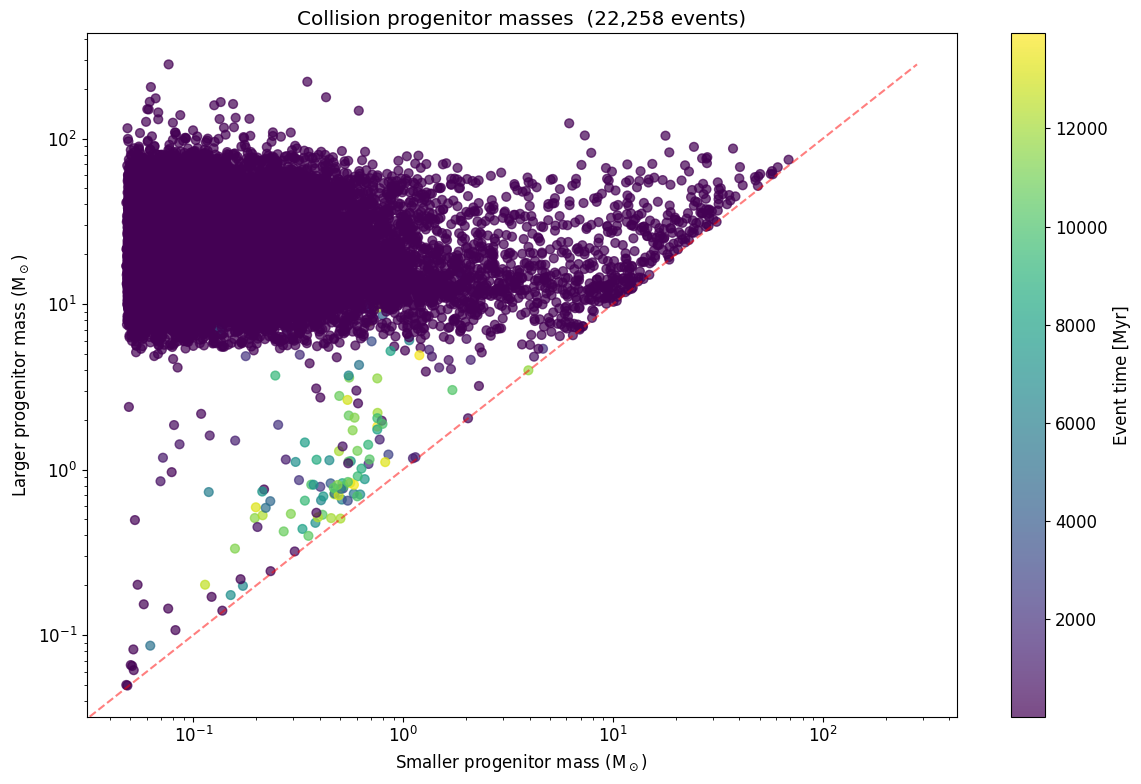

In [88]:
plot_stellar_mass_scatter(collision_bhs_df, evt='collision', time_col='collision_time')


In [89]:
load_bh_formation_data_enhanced_with_units(data)


TypeError: expected str, bytes or os.PathLike object, not DataFrame

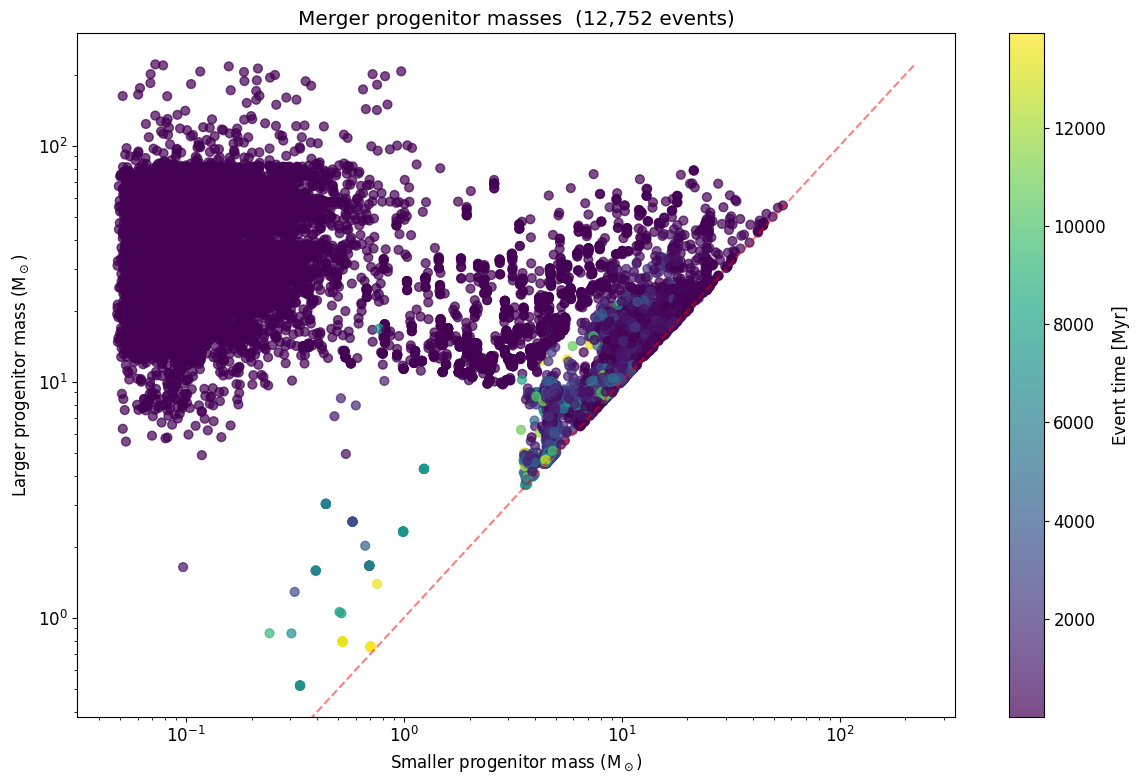

In [40]:
plot_stellar_mass_scatter(merger_bhs_df,   evt='merger',    time_col='merger_time')


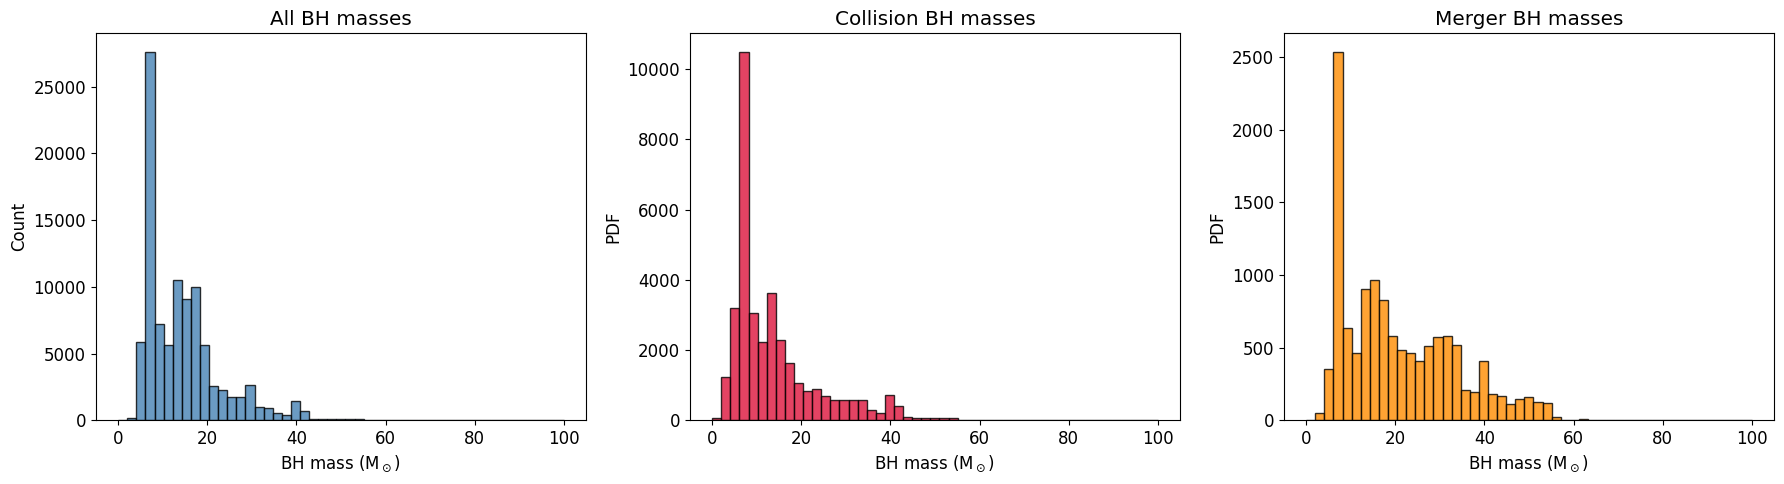

In [41]:
plot_bh_mass_histograms(all_bhs_df, collision_bhs_df, merger_bhs_df,bins=np.linspace(0,100))


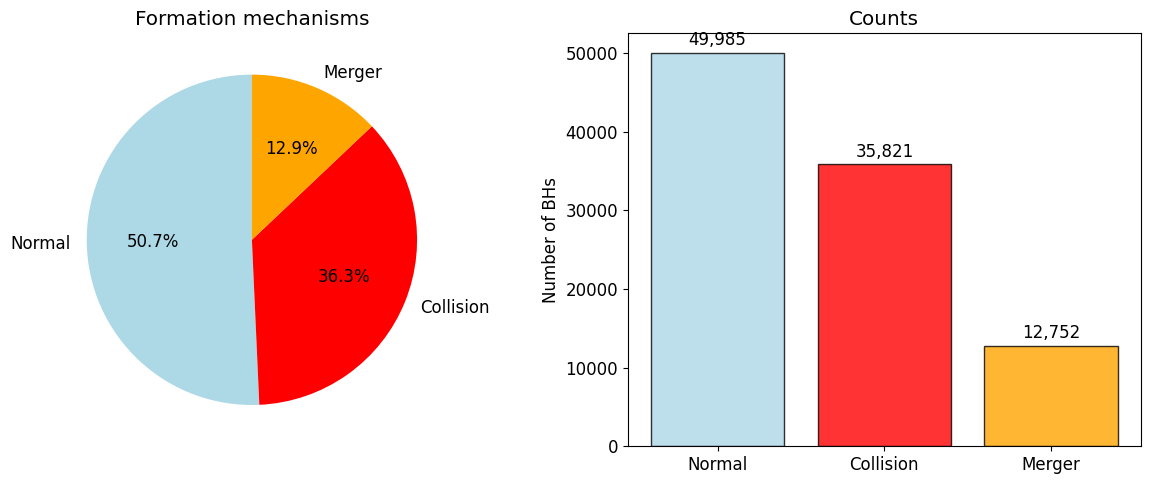

In [42]:
plot_formation_mechanisms(all_bhs_df, collision_bhs_df, merger_bhs_df)


In [43]:
weird = merger_bhs_df[(merger_bhs_df['time'] <merger_bhs_df['merger_time'])]
weird
merger_bhs_df.columns


Index(['merger_time', 'merger_type', 'id_rem', 'mass_rem', 'id1', 'm1', 'id2',
       'm2', 'merger_location', 'type_rem', 'type1', 'type2', 'time', 'r',
       'binary', 'ID', 'zams_m', 'm_progenitor', 'bh_mass', 'bh_spin',
       'birth_kick', 'model_name', 'model_N', 'model_rv', 'model_rg',
       'model_Z', 'formation_mechanism', 'units_converted',
       'progenitor_mass_1', 'progenitor_mass_2', 'stellar_type_1',
       'stellar_type_2', 'total_progenitor_mass', 'mass_ratio'],
      dtype='object')

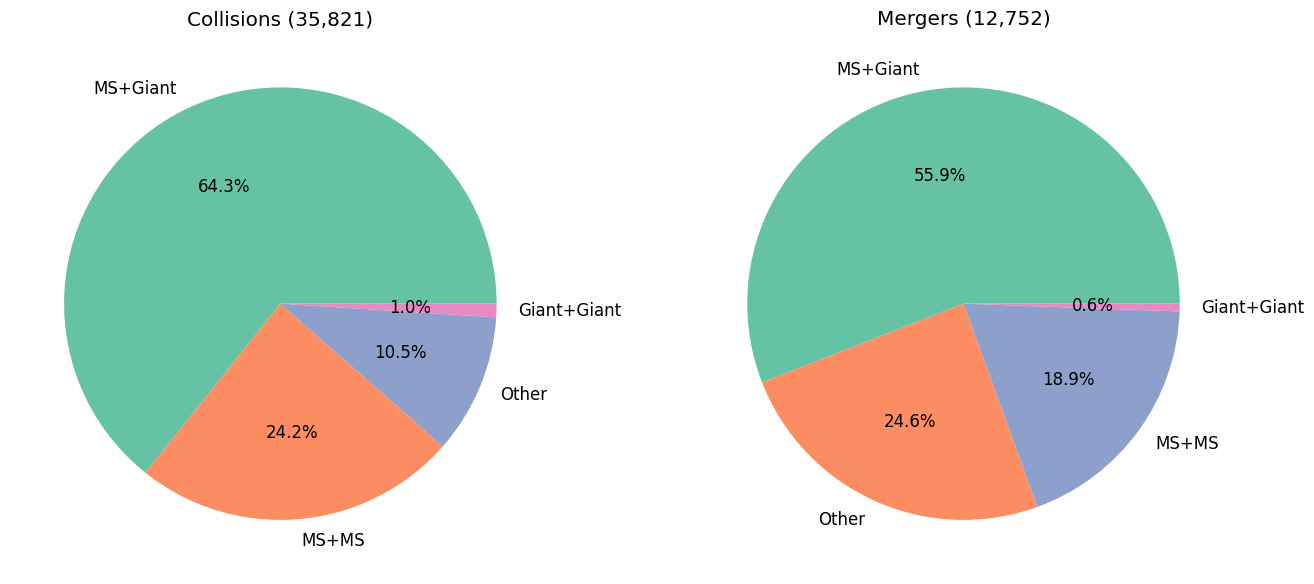

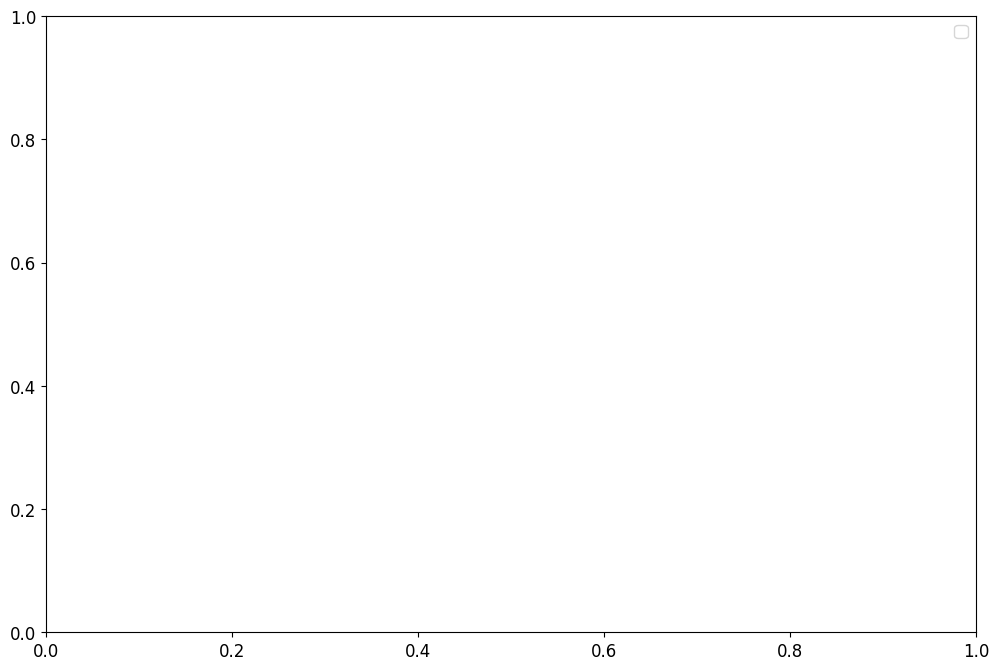

In [44]:
plot_stellar_type_categories(collision_bhs_df, merger_bhs_df)


In [45]:
merger_bhs_df.columns

Index(['merger_time', 'merger_type', 'id_rem', 'mass_rem', 'id1', 'm1', 'id2',
       'm2', 'merger_location', 'type_rem', 'type1', 'type2', 'time', 'r',
       'binary', 'ID', 'zams_m', 'm_progenitor', 'bh_mass', 'bh_spin',
       'birth_kick', 'model_name', 'model_N', 'model_rv', 'model_rg',
       'model_Z', 'formation_mechanism', 'units_converted',
       'progenitor_mass_1', 'progenitor_mass_2', 'stellar_type_1',
       'stellar_type_2', 'total_progenitor_mass', 'mass_ratio'],
      dtype='object')

In [46]:
def classify_types(row):
    # Dictionary mapping stellar type numbers to their descriptions
    star_types = {
        0: "deeply or fully convective low mass MS star",
        1: "Main Sequence star",
        2: "Hertzsprung Gap",
        3: "First Giant Branch",
        4: "Core Helium Burning",
        5: "First Asymptotic Giant Branch",
        6: "Second Asymptotic Giant Branch",
        7: "Main Sequence Naked Helium star",
        8: "Hertzsprung Gap Naked Helium star",
        9: "Giant Branch Naked Helium star",
        10: "Helium White Dwarf",
        11: "Carbon/Oxygen White Dwarf",
        12: "Oxygen/Neon White Dwarf",
        13: "Neutron Star",
        14: "Black Hole",
        15: "Massless Supernova"
    }
    
    # Get the star type descriptions for the given type numbers
    type1_desc = star_types.get(row['type1'], "Unknown")
    type2_desc = star_types.get(row['type2'], "Unknown")
    
    # Classify the collision/merger based on the star types
    ms = {0, 1}
    giants = set(range(2, 10))
    
    if row['type1'] in ms and row['type2'] in ms:
        category = 'MS+MS'
    elif row['type1'] in giants and row['type2'] in giants:
        category = 'Giant+Giant'
    elif (row['type1'] in ms and row['type2'] in giants) or (row['type2'] in ms and row['type1'] in giants):
        category = 'MS+Giant'
    elif row['type1'] >= 10 or row['type2'] >= 10:
        category = 'Other'
    else:
        category = 'Unknown'
    
    # Return a pandas Series with the results
    return pd.Series([category, type1_desc, type2_desc])


In [47]:
#merger types

In [48]:
merged = collision_bhs_df


In [49]:
merged[['category', 'type1_desc', 'type2_desc']] = merged.apply(classify_types , axis=1)
merged

,collision_time,collision_type,idm,mm,id1,m1,id2,m2,collision_location,typem,...,units_converted,progenitor_mass_1,progenitor_mass_2,stellar_type_1,stellar_type_2,total_progenitor_mass,mass_ratio,category,type1_desc,type2_desc
0,1.031471,single-single,1782184,14.837511,232722,14.638643,102184,0.198868,0.110481,1,...,True,14.638643,0.198868,1,0,14.837511,0.013585,MS+MS,Main Sequence star,deeply or fully convective low mass MS star
1,1.625898,single-single,1869642,14.062297,189642,0.076694,267316,13.985636,0.277770,1,...,True,0.076694,13.985636,0,1,14.062330,0.005484,MS+MS,deeply or fully convective low mass MS star,Main Sequence star
2,1.676013,single-single,1936824,13.430638,256824,0.547746,920309,12.882918,0.126704,1,...,True,0.547746,12.882918,1,1,13.430664,0.042517,MS+MS,Main Sequence star,Main Sequence star
3,1.758030,single-single,1740170,27.581603,60170,27.284060,94603,0.297561,0.118310,1,...,True,27.284060,0.297561,1,0,27.581621,0.010906,MS+MS,Main Sequence star,deeply or fully convective low mass MS star
4,1.872144,binary-single,1717142,37.700812,161043,0.055559,37142,37.645257,0.081335,1,...,True,0.055559,37.645257,0,1,37.700817,0.001476,MS+MS,deeply or fully convective low mass MS star,Main Sequence star
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35816,13728.111241,binary-binary,0,1.668251,908013,0.991367,1369598,0.676885,0.101409,1,...,True,0.991367,0.676885,1,1,1.668251,0.682779,MS+MS,Main Sequence star,Main Sequence star
35817,13728.111241,binary-binary,0,1.668251,908013,0.991367,1369598,0.676885,0.101409,1,...,True,0.991367,0.676885,1,1,1.668251,0.682779,MS+MS,Main Sequence star,Main Sequence star
35818,13728.111241,binary-binary,0,1.668251,908013,0.991367,1369598,0.676885,0.101409,1,...,True,0.991367,0.676885,1,1,1.668251,0.682779,MS+MS,Main Sequence star,Main Sequence star
35819,13728.111241,binary-binary,0,1.668251,908013,0.991367,1369598,0.676885,0.101409,1,...,True,0.991367,0.676885,1,1,1.668251,0.682779,MS+MS,Main Sequence star,Main Sequence star


In [50]:
# Finding percentage of each category for col
category_counts = pd.DataFrame(merged.groupby('category').count()['units_converted'])
category_counts.rename(columns={'units_converted': 'count'}, inplace=True)


category_counts['percentage'] = (category_counts['count'] / category_counts['count'].sum()) * 100 # choosing not to round since giant giant % goes to 0 
category_counts

,count,percentage
category,,
Giant+Giant,361,1.007789
MS+Giant,23027,64.283521
MS+MS,8683,24.239971
Other,3750,10.468719


In [ ]:
# Create separete dataframes for each col category
ms_ms = merged[merged['category'] == 'MS+MS'].copy()
ms_giant = merged[merged['category'] == 'MS+Giant'].copy()
giant_giant = merged[merged['category'] == 'Giant+Giant'].copy()
other = merged[merged['category'] == 'Other'].copy()

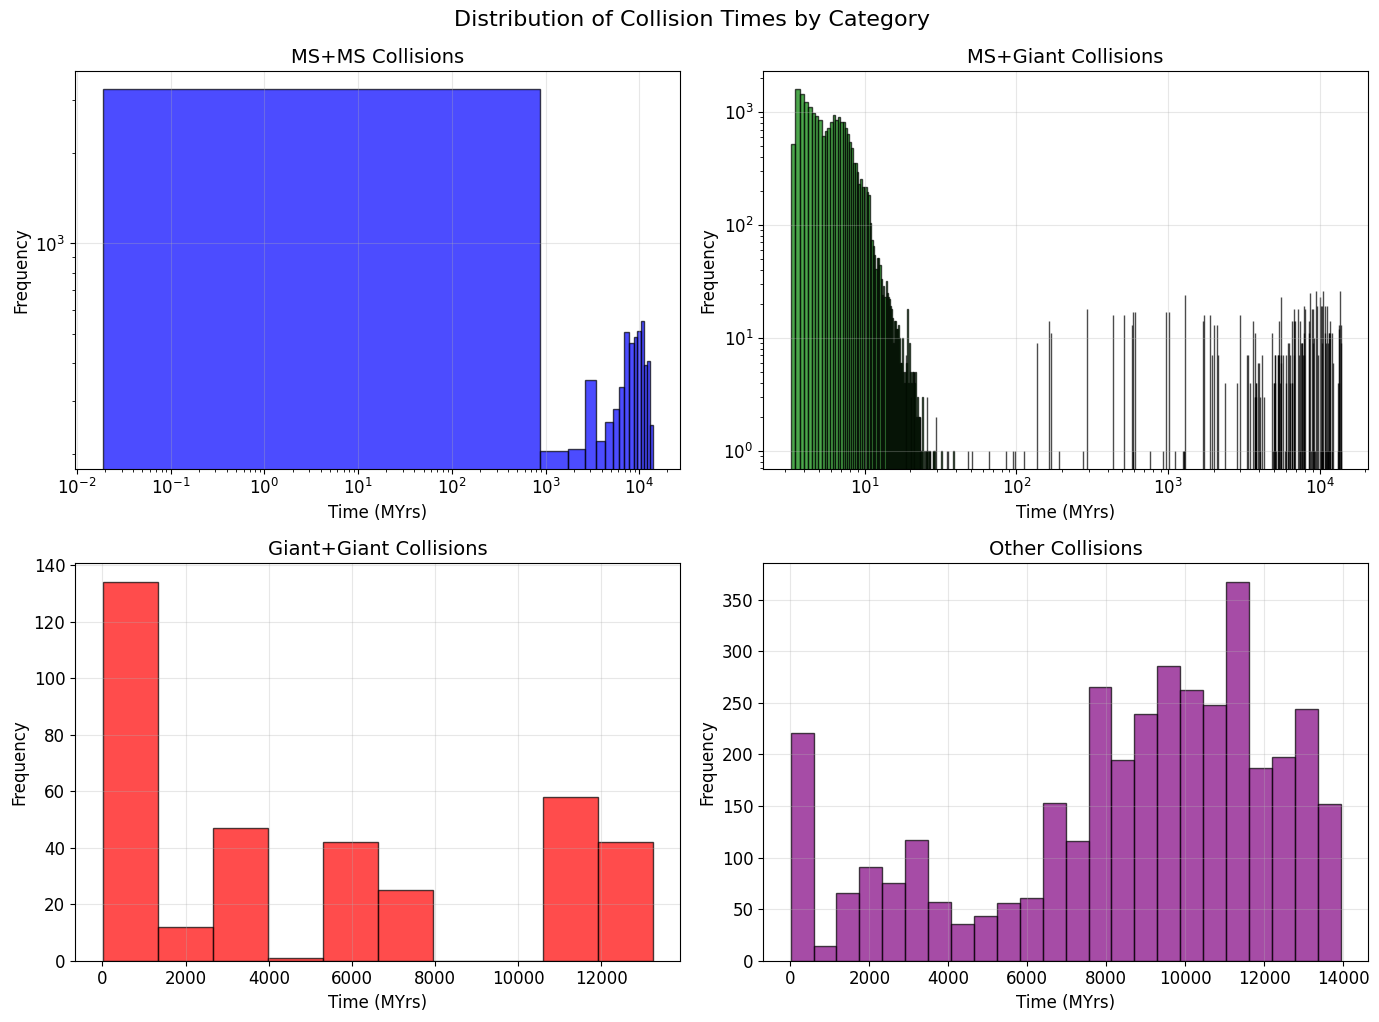

In [ ]:
#plotting histgrams for each type

# Set up a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

# Define a common set of bins for all histograms
all_times = merged['collision_time']

bins = 'auto'

# Plot histogram for MS+MS collisions
axs[0].hist(ms_ms['collision_time'], bins=bins, color='blue', alpha=0.7, edgecolor='black')
axs[0].set_title('MS+MS Collisions', fontsize=14)
axs[0].set_xlabel('Time (MYrs)', fontsize=12)
axs[0].set_ylabel('Frequency', fontsize=12)
axs[0].grid(alpha=0.3)
axs[0].set_yscale('log')
axs[0].set_xscale('log')



# Plot histogram for MS+Giant collisions
axs[1].hist(ms_giant['collision_time'], bins=bins, color='green', alpha=0.7, edgecolor='black')
axs[1].set_title('MS+Giant Collisions', fontsize=14)
axs[1].set_xlabel('Time (MYrs)', fontsize=12)
axs[1].set_ylabel('Frequency', fontsize=12)
axs[1].grid(alpha=0.3)
axs[1].set_yscale('log')
axs[1].set_xscale('log')

# Plot histogram for Giant+Giant collisions
axs[2].hist(giant_giant['collision_time'], bins=bins, color='red', alpha=0.7, edgecolor='black')
axs[2].set_title('Giant+Giant Collisions', fontsize=14)
axs[2].set_xlabel('Time (MYrs)', fontsize=12)
axs[2].set_ylabel('Frequency', fontsize=12)
axs[2].grid(alpha=0.3)

# Plot histogram for Other collisions
axs[3].hist(other['collision_time'], bins=bins, color='purple', alpha=0.7, edgecolor='black')
axs[3].set_title('Other Collisions', fontsize=14)
axs[3].set_xlabel('Time (MYrs)', fontsize=12)
axs[3].set_ylabel('Frequency', fontsize=12)
axs[3].grid(alpha=0.3)

plt.tight_layout()
plt.suptitle('Distribution of Collision Times by Category', fontsize=16, y=1.02)
plt.show()

In [53]:
#now for mergers

In [54]:
merged2 = merger_bhs_df
merged2[['category', 'type1_desc', 'type2_desc']] = merged2.apply(classify_types , axis=1)
# Finding percentage of each category for col
category_counts2 = pd.DataFrame(merged2.groupby('category').count()['units_converted'])
category_counts2.rename(columns={'units_converted': 'count'}, inplace=True)


category_counts2['percentage'] = (category_counts2['count'] / category_counts2['count'].sum()) * 100 # choosing not to round since giant giant % goes to 0 
category_counts2
# Create separete dataframes for each merger category
ms_ms2 = merged2[merged2['category'] == 'MS+MS'].copy()
ms_giant2 = merged2[merged2['category'] == 'MS+Giant'].copy()
giant_giant2 = merged2[merged2['category'] == 'Giant+Giant'].copy()
other2 = merged2[merged2['category'] == 'Other'].copy()

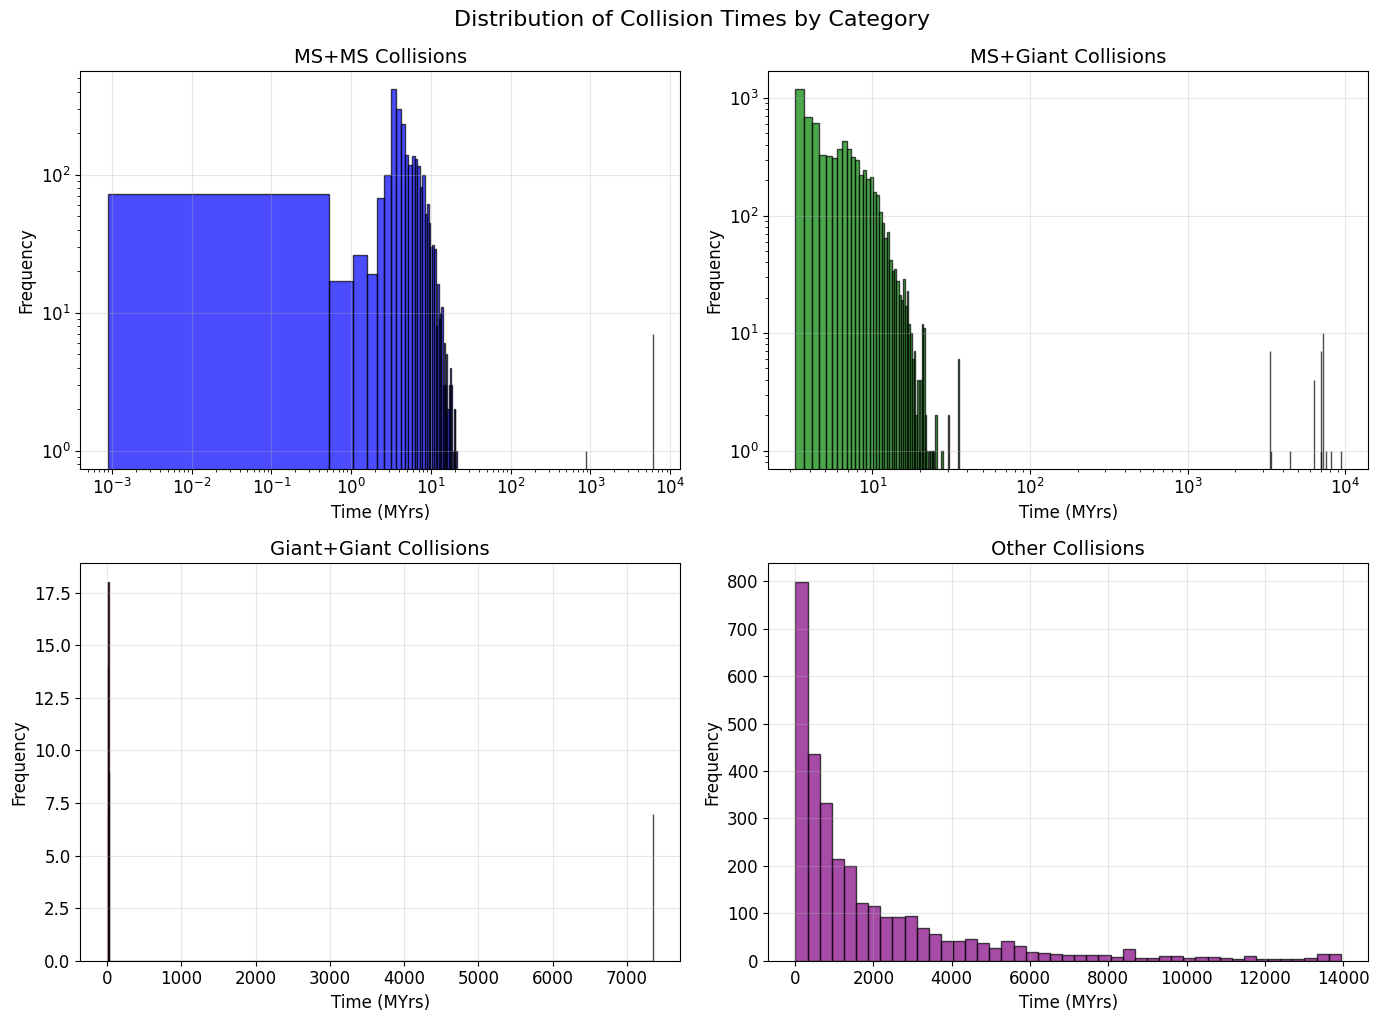

In [ ]:
#plotting histgrams for each type

# Set up a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

# Define a common set of bins for all histograms
all_times2 = merged2['merger_time']

bins = 'auto'

# Plot histogram for MS+MS collisions
axs[0].hist(ms_ms2['merger_time'], bins=bins, color='blue', alpha=0.7, edgecolor='black')
axs[0].set_title('MS+MS Collisions', fontsize=14)
axs[0].set_xlabel('Time (MYrs)', fontsize=12)
axs[0].set_ylabel('Frequency', fontsize=12)
axs[0].grid(alpha=0.3)
axs[0].set_yscale('log')
axs[0].set_xscale('log')



# Plot histogram for MS+Giant collisions
axs[1].hist(ms_giant2['merger_time'], bins=bins, color='green', alpha=0.7, edgecolor='black')
axs[1].set_title('MS+Giant Collisions', fontsize=14)
axs[1].set_xlabel('Time (MYrs)', fontsize=12)
axs[1].set_ylabel('Frequency', fontsize=12)
axs[1].grid(alpha=0.3)
axs[1].set_yscale('log')
axs[1].set_xscale('log')

# Plot histogram for Giant+Giant collisions
axs[2].hist(giant_giant2['merger_time'], bins=bins, color='red', alpha=0.7, edgecolor='black')
axs[2].set_title('Giant+Giant Collisions', fontsize=14)
axs[2].set_xlabel('Time (MYrs)', fontsize=12)
axs[2].set_ylabel('Frequency', fontsize=12)
axs[2].grid(alpha=0.3)

# Plot histogram for Other collisions
axs[3].hist(other2['merger_time'], bins=bins, color='purple', alpha=0.7, edgecolor='black')
axs[3].set_title('Other Collisions', fontsize=14)
axs[3].set_xlabel('Time (MYrs)', fontsize=12)
axs[3].set_ylabel('Frequency', fontsize=12)
axs[3].grid(alpha=0.3)

plt.tight_layout()
plt.suptitle('Distribution of Collision Times by Category', fontsize=16, y=1.02)
plt.show()

In [56]:
cat = other2.groupby('type1_desc').count
cat

<bound method GroupBy.count of <pandas.core.groupby.generic.DataFrameGroupBy object at 0x000001E5910F2C90>>

# Trying to find most common types of collisions and mergers

In [57]:
import pandas as pd
from sklearn.cluster import KMeans



# Choose relevant features for clustering
features = [
    'mass_ratio', 'idm', 'mm', 'id1', 'm1', 'id2',
       'm2', 'collision_location', 'typem', 'type1', 'type2', 'time', 'r',
       'binary', 
    
]

# Drop rows with missing values in these columns
data = collision_bhs_df.dropna(subset=features).copy()


In [58]:
# Fit KMeans with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
data['cluster'] = kmeans.fit_predict(data[features])


In [59]:
# Calculate median for each cluster
median_properties = data.groupby('cluster')[features].median().reset_index()
print(median_properties)
#doesnt seem too useful but maybe I need to choose my features 

   cluster  mass_ratio        idm         mm        id1         m1        id2  \
0        0    0.007705  1922651.0  15.626007  1723590.0  13.803386   526882.0   
1        1    0.360918        0.0   2.697998   184020.0   0.595907   370573.0   
2        2    0.571388        0.0   1.631749  1266774.0   0.689517  1833224.0   
3        3    0.007172  1041617.5  16.992620   327773.0   0.703984   375794.0   
4        4    0.007932  1845290.0  16.177609   441427.0   0.145762  1752025.0   

          m2  collision_location  typem  type1  type2      time         r  \
0   0.162440            0.157507    4.0    4.0    0.0  6.332766  0.193568   
1   0.966803            0.049458    4.0    1.0    1.0  7.367266  0.123232   
2   0.831606            0.034997    1.0    1.0    1.0  6.007819  0.140163   
3  10.560742            0.129783    4.0    1.0    1.0  6.678410  0.166481   
4  15.256443            0.135975    4.0    0.0    4.0  6.374050  0.177110   

   binary  
0     0.0  
1     1.0  
2     1.0  
3 

In [60]:
collision_bhs_df.columns    

Index(['collision_time', 'collision_type', 'idm', 'mm', 'id1', 'm1', 'id2',
       'm2', 'collision_location', 'typem', 'type1', 'type2', 'time', 'r',
       'binary', 'ID', 'zams_m', 'm_progenitor', 'bh_mass', 'bh_spin',
       'birth_kick', 'model_name', 'model_N', 'model_rv', 'model_rg',
       'model_Z', 'formation_mechanism', 'units_converted',
       'progenitor_mass_1', 'progenitor_mass_2', 'stellar_type_1',
       'stellar_type_2', 'total_progenitor_mass', 'mass_ratio', 'category',
       'type1_desc', 'type2_desc'],
      dtype='object')

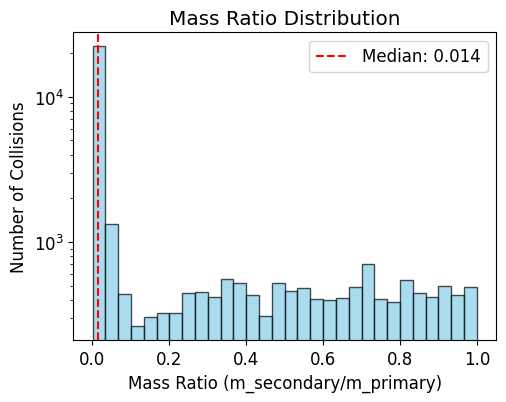

In [61]:
def plot_mass_ratio_distribution(collision_bhs_df):

    
    plt.figure(figsize=(12, 4))
    
    # Subplot 1: Mass ratio histogram
    plt.subplot(1, 2, 1)
    plt.hist(collision_bhs_df['mass_ratio'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.xlabel('Mass Ratio (m_secondary/m_primary)')
    plt.ylabel('Number of Collisions')
    plt.title('Mass Ratio Distribution')
    plt.axvline(collision_bhs_df['mass_ratio'].median(), color='red', linestyle='--', 
                label=f'Median: {collision_bhs_df["mass_ratio"].median():.3f}')
    plt.legend()
    plt.yscale('log')
    


# Create visualization
plot_mass_ratio_distribution(collision_bhs_df)


In [77]:
col= load_collision_data_enhanced_with_units('data/N8.0rv0.5rg8.0Z0.0002')
bh=load_bh_formation_data_enhanced_with_units('data/N8.0rv0.5rg8.0Z0.0002')
bh_test = pd.merge(
                col, 
                bh, 
                left_on='idm', 
                right_on='ID', 
                how='inner'
            )
plt.figure(figsize=(8,6))
bh_test['mass_small']=np.minimum(bh_test['m1'],bh_test['m2'])
bh_test['mass_large']=np.maximum(bh_test['m1'],bh_test['m2'])

scatter = plt.scatter(np.log(bh_test['mass_small']), np.log(bh_test['mass_large']), c=bh_test['time'], cmap='viridis', alpha=0.7)
plt.xlabel('Mass of Smaller Star ($M_\\odot$)')
plt.ylabel('Mass of Larger Star ($M_\\odot$)')
plt.title('Scatter Plot of Colliding Star Masses')
cbar = plt.colorbar(scatter)
cbar.set_label('Collision Time (Myr)')
plt.tight_layout()
plt.show()

TypeError: Can only merge Series or DataFrame objects, a <class 'tuple'> was passed

In [76]:
bh

,time,collision_type,idm,mm,id1,m1,id2,m2,r,typem,type1,type2
0,0.018791,single-single,876002,13.935326,36002,0.089801,106367,13.845508,0.263943,1,0,1
1,0.039342,single-single,899757,4.611515,155756,4.330481,59757,0.281033,0.121646,1,1,0
2,0.133036,binary-single,1050073,26.796055,210073,0.055491,512714,26.740541,0.483756,1,0,1
3,0.254088,single-single,925080,8.865251,202129,0.154172,85080,8.711071,0.161250,1,0,1
4,0.295142,single-single,840197,79.638051,197,0.110167,40380,79.527749,0.063923,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4942,13456.632370,single-single,927943,1.506344,581968,0.337410,927942,1.169498,0.049811,5,0,5
4943,13457.441042,single-single,970929,1.764214,155194,0.791829,970928,0.972470,0.056285,5,12,3
4944,13459.260553,single-single,1110650,1.087069,281916,0.601129,270650,0.486181,0.020278,5,11,3
4945,13459.395332,single-single,1110651,1.836116,338774,0.751320,1110650,1.085729,0.016443,4,12,5
